# **Import Library**

In [1]:
!pip install --upgrade gensim -qq

In [ ]:
import gensim
print("Versi gensim:", gensim.__version__)

Versi gensim: 4.3.3


In [ ]:
!pip install indonlp==0.2.0 -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.6/110.6 kB 2.7 MB/s eta 0:00:00


In [ ]:
!pip install num2words -qq

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 4.4 MB/s eta 0:00:00


In [ ]:
!pip install pyenchant -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 2.0 MB/s eta 0:00:00


In [ ]:
!pip install Sastrawi -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.0 MB/s eta 0:00:00


In [ ]:
from indoNLP.preprocessing import remove_url, remove_html, replace_slang, replace_word_elongation
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from num2words import num2words

# **Import Library**

In [ ]:
# =========================== #
# 📦 IMPORT LIBRARIES        #
# =========================== #

# Peringatan
import warnings
warnings.filterwarnings('ignore')

# Data & Utility
import pandas as pd
import numpy as np
import re
import string
import pickle
from tqdm import tqdm

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Preprocessing Teks dan Embedding
from gensim.models import Word2Vec
from gensim.models.fasttext import load_facebook_model
from gensim.utils import simple_preprocess
from gensim.corpora.wikicorpus import WikiCorpus

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D,
    Dense, Dropout, BatchNormalization, LayerNormalization
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.losses import BinaryCrossentropy

# Sklearn
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, roc_curve, roc_auc_score
)

# Imbalanced-learn (SMOTE)
from imblearn.over_sampling import SMOTE


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU terdeteksi: {gpus}")
else:
    print("❌ GPU tidak terdeteksi. Gunakan CPU.")

✅ GPU terdeteksi: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# **Baca Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/resources/Data_Bersih.csv', quotechar='"', usecols=['"full_text"'])
df

# **Preprocessing**

**Case Folding**

In [ ]:
def case_folding(text):
    return text.lower()

In [ ]:
# Salin isi kolom asli ke kolom baru untuk dibandingkan
df['before_case_folding'] = df['"full_text"'].astype(str)

# Terapkan case folding ke kolom baru
df['after_case_folding'] = df['before_case_folding'].apply(case_folding)

df_display = df[['before_case_folding', 'after_case_folding']]
df_display.head()

# **Clean Text**

In [ ]:
def bersihkan_teks(df):
    def clean_text(text):
        text = text.lower()
        text = re.sub(r'http\S+|www.\S+', '', text)
        text = re.sub(r'@\S+', '', text)
        text = re.sub(r'#\w+', '', text)
        text = re.sub(r'[^\x00-\x7F]+', '', text)
        text = re.sub(r'(\w)-(\w)', r'\1 \2', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = re.sub(r'\b[a-zA-Z]\b', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def ganti_angka_ke_teks(text):
        def ganti(match):
            angka = match.group()
            try:
                return num2words(int(angka), lang='id')
            except:
                return angka
        return re.sub(r'\b\d+\b', ganti, text)

    def indoNLP_clean(text):
        text = remove_url(text)
        text = remove_html(text)
        text = replace_slang(text)
        text = replace_word_elongation(text)
        return text

    def hapus_kata_tawa(text):
        text = re.sub(r'\b(?:w[kw]+|h[aei]+)+\b', '', text)
        text = re.sub(r'\b(?:awok)+\b', '', text)
        text = re.sub(r'\b[a-zA-Z]\b', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    # Drop baris NaN atau kosong
    df = df.dropna(subset=['"full_text"'])
    df = df[df['"full_text"'].astype(str).str.strip() != '']

    # Transformasi awal tanpa ganti/hapus kata/frasa
    df['"full_text"'] = df['"full_text"'].astype(str)
    df['"full_text"'] = df['"full_text"'].apply(clean_text)
    df['"full_text"'] = df['"full_text"'].apply(ganti_angka_ke_teks)
    df['"full_text"'] = df['"full_text"'].apply(indoNLP_clean)
    df['"full_text"'] = df['"full_text"'].apply(hapus_kata_tawa)

    # Drop kosong dan duplikat
    df = df[df['"full_text"'].str.strip() != '']
    df = df.drop_duplicates(subset=['"full_text"'])
    df = df.reset_index(drop=True)

    return df


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'(\w)-(\w)', r'\1 \2', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\b[a-zA-Z]\b', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def ganti_angka_ke_teks(text):
    def ganti(match):
        angka = match.group()
        try:
            return num2words(int(angka), lang='id')
        except:
            return angka
    return re.sub(r'\b\d+\b', ganti, text)

def indoNLP_clean(text):
    text = remove_url(text)
    text = remove_html(text)
    text = replace_slang(text)
    text = replace_word_elongation(text)
    return text

def hapus_kata_tawa(text):
    text = re.sub(r'\b(?:w[kw]+|h[aei]+)+\b', '', text)
    text = re.sub(r'\b(?:awok)+\b', '', text)
    text = re.sub(r'\b[a-zA-Z]\b', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def bersihkan_teks(df):
    # Validasi kolom input
    if '"full_text"' not in df.columns or 'after_case_folding' not in df.columns:
        raise KeyError('Kolom yang dibutuhkan tidak ditemukan dalam DataFrame.')

    # Drop baris kosong
    df = df.dropna(subset=['"full_text"'])
    df = df[df['"full_text"'].astype(str).str.strip() != '']

    # Simpan kolom asli untuk referensi
    df['before_cleaning'] = df['"full_text"'].astype(str)

    # Bersihkan teks pada kolom hasil case folding
    df['after_cleaning'] = df['after_case_folding'].apply(clean_text)
    df['after_cleaning'] = df['after_cleaning'].apply(ganti_angka_ke_teks)
    df['after_cleaning'] = df['after_cleaning'].apply(indoNLP_clean)
    df['after_cleaning'] = df['after_cleaning'].apply(hapus_kata_tawa)

    # Bersihkan baris kosong dan duplikat
    df = df[df['after_cleaning'].str.strip() != '']
    df = df.drop_duplicates(subset=['after_cleaning'])
    df = df.reset_index(drop=True)

    # Tampilkan 3 kolom: sebelum cleaning, setelah case folding, dan setelah cleaning
    return df[['after_case_folding', 'after_cleaning']]

In [ ]:
df_hasil = bersihkan_teks(df)
df_hasil

# **Stopwords Removal**

In [ ]:
# Inisialisasi stopwords remover
factory = StopWordRemoverFactory()
stopwords_remover = factory.create_stop_word_remover()

# Fungsi stopwords removal
def hapus_stopwords(text):
    return stopwords_remover.remove(text)

# Terapkan ke kolom 'after_cleaning'
df_hasil['after_stopwords'] = df_hasil['after_cleaning'].apply(hapus_stopwords)

# Tampilkan hanya kolom after_cleaning dan after_stopwords
df_stop = df_hasil[['after_cleaning', 'after_stopwords']]
df_stop

# **Lemmatization**

In [ ]:
# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat kolom sebelum dan sesudah stemming
df_stop['before_stemming'] = df_stop['after_stopwords']
df_stop['after_stemming'] = df_stop['before_stemming'].apply(lambda x: stemmer.stem(str(x)))

# Tampilkan hasil
df_stop[['before_stemming', 'after_stemming']].head()

In [ ]:
df_stop[['before_stemming', 'after_stemming']].to_excel("Data_After_Stemming.xlsx", index=False)

# **Setelah Normalisasi Data, Pelabelan Manual**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from gensim.models.fasttext import load_facebook_model
from gensim.models import Word2Vec, KeyedVectors
from gensim.corpora.wikicorpus import WikiCorpus
from gensim.utils import simple_preprocess
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import normalize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.layers import GlobalMaxPooling1D
from sklearn.metrics import (
    confusion_matrix, classification_report, ConfusionMatrixDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)
from tensorflow.keras.callbacks import ReduceLROnPlateau




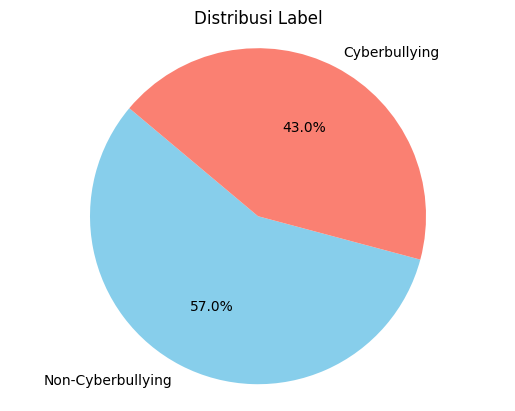

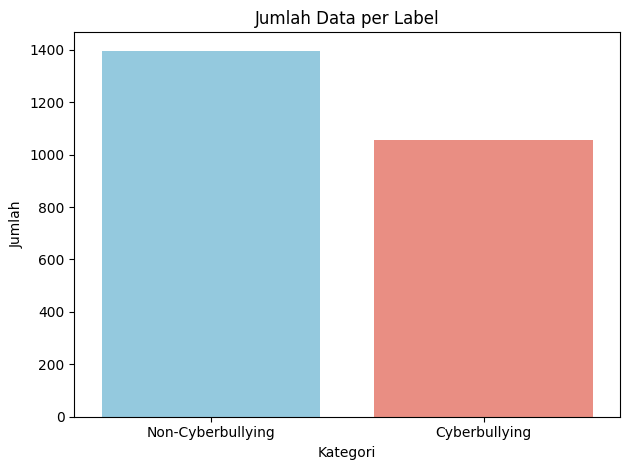

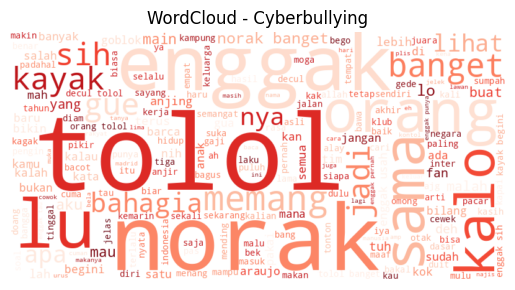

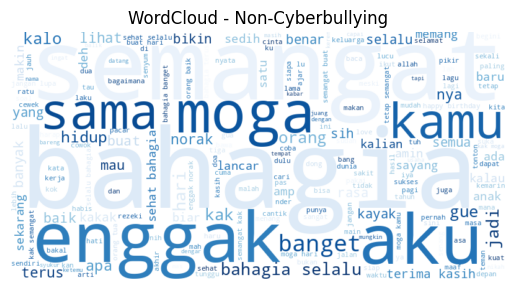

In [ ]:
labeled = pd.read_excel('/content/drive/MyDrive/resources/Data_After_Stemming.xlsx')
texts = labeled["after_stemming"].astype(str).tolist()
labels = labeled["Label"].tolist()

# Visualisasi
label_counts = labeled["Label"].value_counts()
label_names = ["Non-Cyberbullying", "Cyberbullying"]

plt.pie(label_counts, labels=label_names, autopct="%1.1f%%", colors=["skyblue", "salmon"], startangle=140)
plt.title("Distribusi Label")
plt.axis("equal")
plt.show()

sns.barplot(x=label_names, y=label_counts.values, palette=["skyblue", "salmon"])
plt.title("Jumlah Data per Label")
plt.ylabel("Jumlah")
plt.xlabel("Kategori")
plt.tight_layout()
plt.show()

# WordCloud
cyber_texts = labeled[labeled["Label"] == 0]["after_stemming"]
noncyber_texts = labeled[labeled["Label"] == 1]["after_stemming"]
wordcloud_cyber = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(" ".join(cyber_texts))
wordcloud_noncyber = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(" ".join(noncyber_texts))

plt.imshow(wordcloud_cyber, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Cyberbullying")
plt.show()

plt.imshow(wordcloud_noncyber, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Non-Cyberbullying")
plt.show()


In [ ]:
# Tokenizer and padding
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_len = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_len, padding='post')
y = np.array(labels)
vocab_size = len(tokenizer.word_index) + 1


In [ ]:
# ============================
# 2. Convert FastText to GloVe-style file
# ============================

ft_model = load_facebook_model("/content/drive/MyDrive/resources/cc.id.300.bin")
with open("glove_id.txt", "w", encoding="utf-8") as f:
    for word in ft_model.wv.index_to_key:
        vec = ft_model.wv[word]
        vec_str = ' '.join(map(str, vec))
        f.write(f"{word} {vec_str}\n")


In [ ]:
# Path ke file wiki dan output di Google Drive
wiki_bz2_path = "/content/drive/MyDrive/resources/idwiki-latest-pages-articles.xml.bz2"
output_txt_path = "/content/drive/MyDrive/resources/idwiki_text.txt"

# Ubah file Wikipedia XML.bz2 menjadi teks bersih
def extract_wiki_text(wiki_bz2_path, output_txt_path):
    wiki = WikiCorpus(wiki_bz2_path, dictionary={})
    with open(output_txt_path, 'w', encoding='utf-8') as output:
        for text in tqdm(wiki.get_texts(), desc="📖 Extracting wiki"):
            line = ' '.join(text)
            output.write(line + '\n')

extract_wiki_text(wiki_bz2_path, output_txt_path)

# Generator token per kalimat
def read_corpus(file_path):
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            yield simple_preprocess(line)

sentences = list(read_corpus("/content/drive/MyDrive/resources/idwiki_text.txt"))

for dim in [50, 100, 200, 300]:
    model = Word2Vec(sentences=sentences, vector_size=dim, window=5, min_count=5, workers=4)
    model.wv.save_word2vec_format(f"word2vec_id_{dim}.bin", binary=True)


📖 Extracting wiki: 553823it [11:06, 830.76it/s]


In [ ]:
def clean_word(word):
    word = word.lower()
    word = re.sub(r'\d+', '', word)
    word = re.sub(r'[^\w\s]', '', word)
    return word.strip()

def load_embedding_matrix(embedding_type, tokenizer, dim=300, path=None):
    if embedding_type == "fasttext":
        path = path or "/content/drive/MyDrive/resources/cc.id.300.bin"
        print(f"📥 Loading FastText from: {path}")
        wv = load_facebook_model(path).wv
        use_subword = True

    elif embedding_type == "word2vec":
        path = path or f"/content/word2vec_id_{dim}.bin"
        print(f"📥 Loading Word2Vec from: {path}")
        wv = KeyedVectors.load_word2vec_format(path, binary=True)
        use_subword = False

    elif embedding_type == "glove":
        path = path or "/content/glove_id.txt"
        print(f"📥 Loading GloVe from: {path}")
        wv = {}
        with open(path, encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split()
                word = parts[0]
                vector_values = parts[1:]
                if len(vector_values) != dim:
                    continue
                vector = np.asarray(vector_values, dtype='float32')
                wv[word] = vector
        use_subword = False

    else:
        raise ValueError("Unknown embedding type")

    vocab_size = len(tokenizer.word_index) + 1
    matrix = np.zeros((vocab_size, dim))

    if isinstance(wv, dict):
        avg_vector = np.mean(list(wv.values()), axis=0)
    else:
        avg_vector = np.mean([wv[word] for word in wv.index_to_key[:10000]], axis=0)

    oov_words = []
    print(f"\n📌 Contoh kata dari {embedding_type.upper()} {dim}D:")
    count = 0

    for word, i in tokenizer.word_index.items():
        word_clean = clean_word(word)

        if isinstance(wv, dict):
            matrix[i] = wv[word_clean] if word_clean in wv else avg_vector
            if word_clean not in wv:
                oov_words.append(word)
        else:
            if word_clean in wv:
                matrix[i] = wv[word_clean]
            elif use_subword:
                try:
                    matrix[i] = wv.get_vector(word_clean)
                except:
                    matrix[i] = avg_vector
                    oov_words.append(word)
            else:
                matrix[i] = wv[word_clean] if word_clean in wv else avg_vector
                if word_clean not in wv:
                    oov_words.append(word)

        if count < 10 and word_clean in wv:
            print(f"{word_clean}: {wv[word_clean][:5]}...")
            count += 1

    print(f"\n🔍 Total kata dalam tokenizer: {len(tokenizer.word_index)}")
    print(f"🚫 Jumlah kata OOV: {len(oov_words)}")

    # Tambahan: tampilkan 20 kata OOV teratas
    if oov_words:
        print(f"🔎 Kata-kata OOV (maks 20 kata pertama): {oov_words[:20]}")

    # Diagnostik kata penting
    important_words = ['tolol', 'anjing', 'bodoh', 'semangat']
    print("\n🧠 Diagnostik kata penting:")
    for w in important_words:
        w_clean = clean_word(w)
        if isinstance(wv, dict):
            if w_clean in wv:
                print(f"'{w_clean}': {wv[w_clean][:5]}...")
            else:
                print(f"'{w_clean}' tidak ditemukan di embedding.")
        else:
            if w_clean in wv:
                print(f"'{w_clean}': {wv[w_clean][:5]}...")
            else:
                print(f"'{w_clean}' tidak ditemukan di embedding.")

    if embedding_type == 'fasttext':
        matrix = normalize(matrix, norm='l2', axis=1)

    return matrix


# CNN-BiLSTM


📌 Training model: GLOVE 300D
📥 Loading GloVe from: /content/glove_id.txt

📌 Contoh kata dari GLOVE 300D:
bahagia: [-0.00831283 -0.10030977 -0.02840042  0.06064843 -0.04130146]...
enggak: [-0.01656171  0.00548528  0.04379252  0.06003596 -0.02881695]...
semangat: [-0.05048427 -0.039581   -0.02468412  0.00075645 -0.04007722]...
tolol: [ 0.06908239  0.02892014 -0.0007012   0.08941144 -0.01374871]...
norak: [ 0.07936431  0.01482968 -0.07891081  0.01746366  0.01150789]...
banget: [ 0.00823963 -0.03834731  0.00525844  0.03335897 -0.05812761]...
orang: [ 0.04398865 -0.03032926 -0.01770458  0.12002504 -0.08117092]...
aku: [ 0.01258465 -0.05965358  0.09049556  0.29484874  0.02158902]...
sama: [ 0.07707722  0.0165033   0.05018882  0.06665502 -0.01466809]...
moga: [-0.07854926 -0.10443936 -0.02040526  0.22406685 -0.13021791]...

🔍 Total kata dalam tokenizer: 6098
🚫 Jumlah kata OOV: 945
🔎 Kata-kata OOV (maks 20 kata pertama): ['<OOV>', 'decul', 'araujo', 'anjg', 'thuram', 'bjir', 'bucin', 'emyu', 

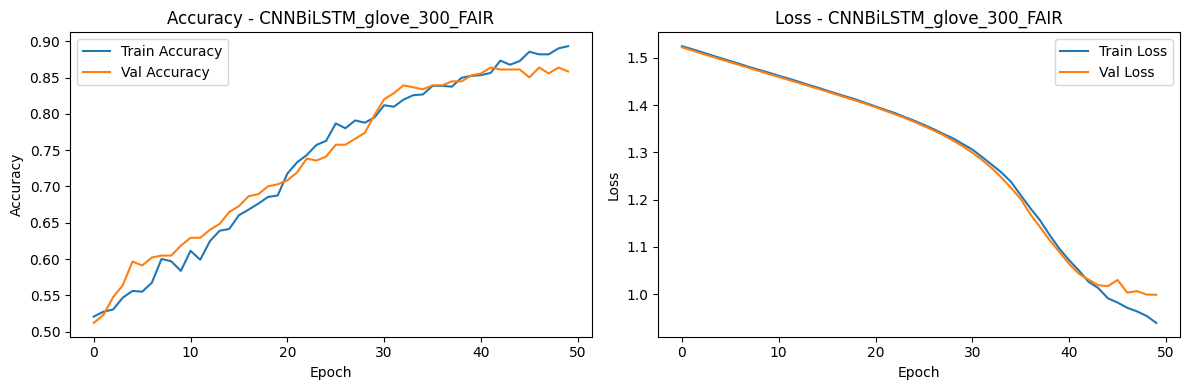

<Figure size 600x400 with 0 Axes>

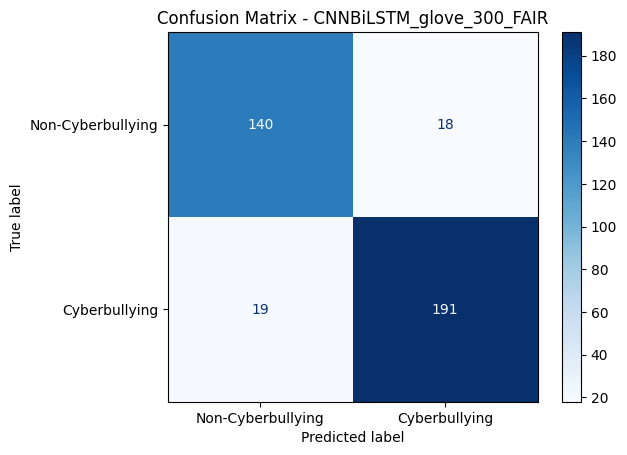

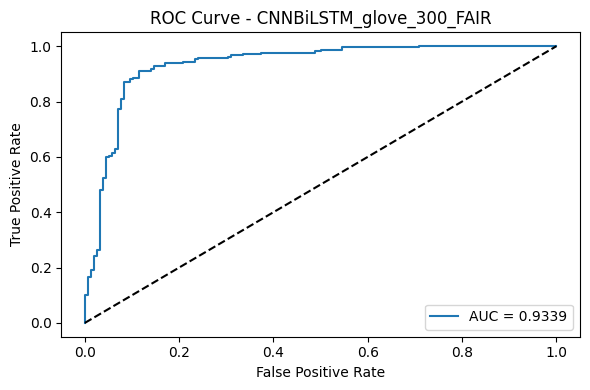

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.88      0.89      0.88       158
    Cyberbullying       0.91      0.91      0.91       210

         accuracy                           0.90       368
        macro avg       0.90      0.90      0.90       368
     weighted avg       0.90      0.90      0.90       368


✅ Accuracy: 0.8995, AUC: 0.9339, Precision: 0.9139, Recall: 0.9095, F1: 0.9117

📌 Training model: WORD2VEC 50D
📥 Loading Word2Vec from: /content/word2vec_id_50.bin

📌 Contoh kata dari WORD2VEC 50D:
bahagia: [ 1.555484  -1.5180684  4.9730716 -1.0975758  1.1231126]...
enggak: [ 0.5154892   0.72853446  0.45663002 -0.37144345  0.13179946]...
semangat: [-0.99712586 -6.8990803   3.5418825   1.8863772   2.1949656 ]...
tolol: [-0.0947442  -0.01799688  0.06178674  0.13510667 -0.25912404]...
norak: [-0.56937814  0.5166423   0.45361045 -0.30127692  0.4032841 ]...
banget: [-0.12285744  1.2783002   0.85558516 -1.6638255   

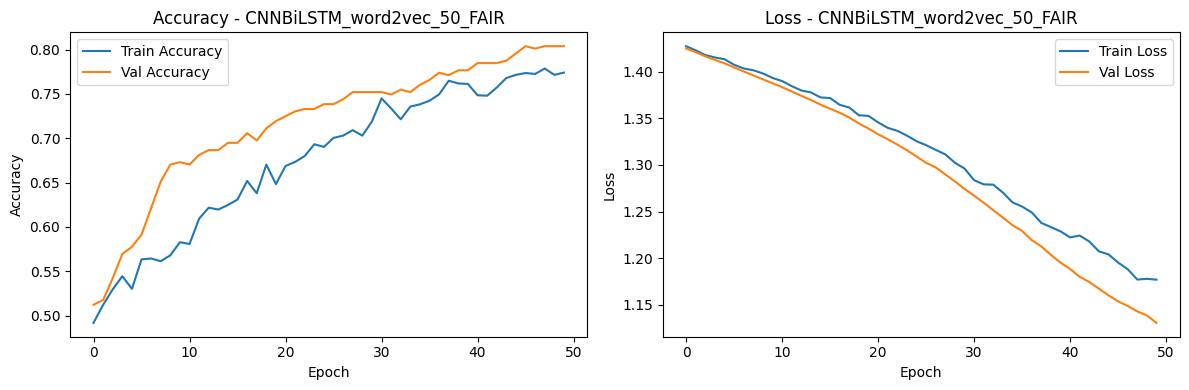

<Figure size 600x400 with 0 Axes>

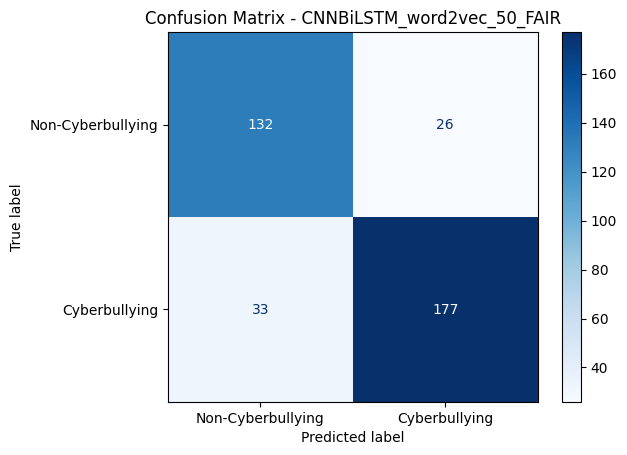

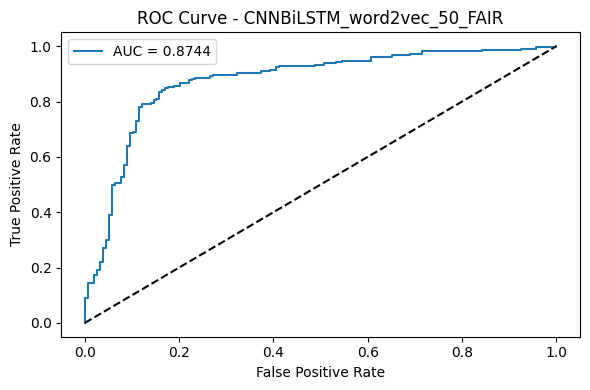

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.80      0.84      0.82       158
    Cyberbullying       0.87      0.84      0.86       210

         accuracy                           0.84       368
        macro avg       0.84      0.84      0.84       368
     weighted avg       0.84      0.84      0.84       368


✅ Accuracy: 0.8397, AUC: 0.8744, Precision: 0.8719, Recall: 0.8429, F1: 0.8571

📌 Training model: WORD2VEC 100D
📥 Loading Word2Vec from: /content/word2vec_id_100.bin

📌 Contoh kata dari WORD2VEC 100D:
bahagia: [ 2.005796   2.4735165 -1.8078803  0.6675258 -2.9516284]...
enggak: [ 0.13034904 -0.03150576 -0.397664    0.04419045  0.24909385]...
semangat: [1.1659876  3.4657774  0.5244758  0.28711873 0.92092216]...
tolol: [ 0.33882636 -0.1848195  -0.02667955 -0.10209899 -0.09796022]...
norak: [-0.12416901  0.08430327 -0.47889015  0.24740651  0.02863069]...
banget: [-0.04130686  0.2832475  -0.75336087  0.4072336   0.

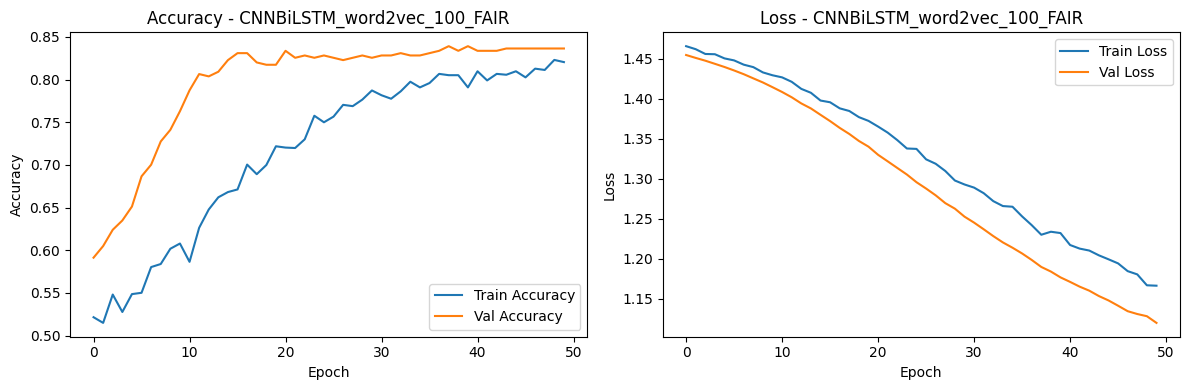

<Figure size 600x400 with 0 Axes>

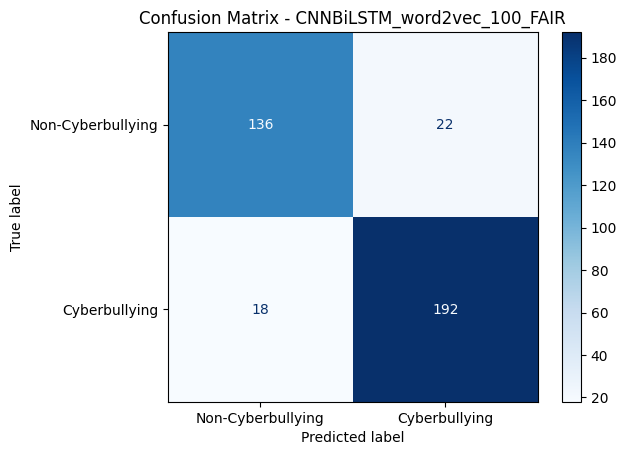

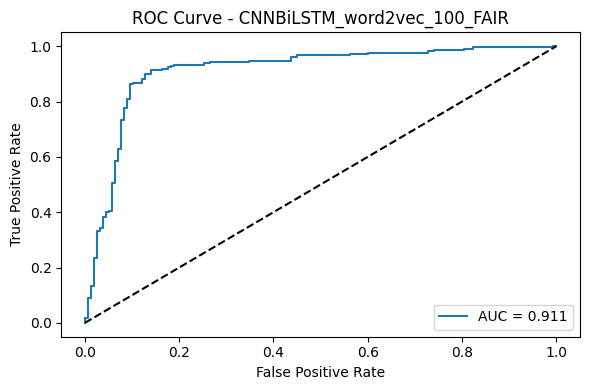

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.88      0.86      0.87       158
    Cyberbullying       0.90      0.91      0.91       210

         accuracy                           0.89       368
        macro avg       0.89      0.89      0.89       368
     weighted avg       0.89      0.89      0.89       368


✅ Accuracy: 0.8913, AUC: 0.911, Precision: 0.8972, Recall: 0.9143, F1: 0.9057

📌 Training model: WORD2VEC 200D
📥 Loading Word2Vec from: /content/word2vec_id_200.bin

📌 Contoh kata dari WORD2VEC 200D:
bahagia: [ 1.7550194   1.432479   -1.1399378   2.6594734   0.94629663]...
enggak: [ 0.19981514 -0.02408739 -0.6850773   1.1911632  -0.3665811 ]...
semangat: [ 0.04205265  1.4077189  -0.65542054  0.68504095  0.3100522 ]...
tolol: [ 0.29695645  0.04840705 -0.33272487  0.29504514 -0.06767282]...
norak: [ 0.47483715  0.5674003  -0.368438    0.5593894  -0.7815402 ]...
banget: [ 0.611466   -0.35924315 -2.115331    1.528

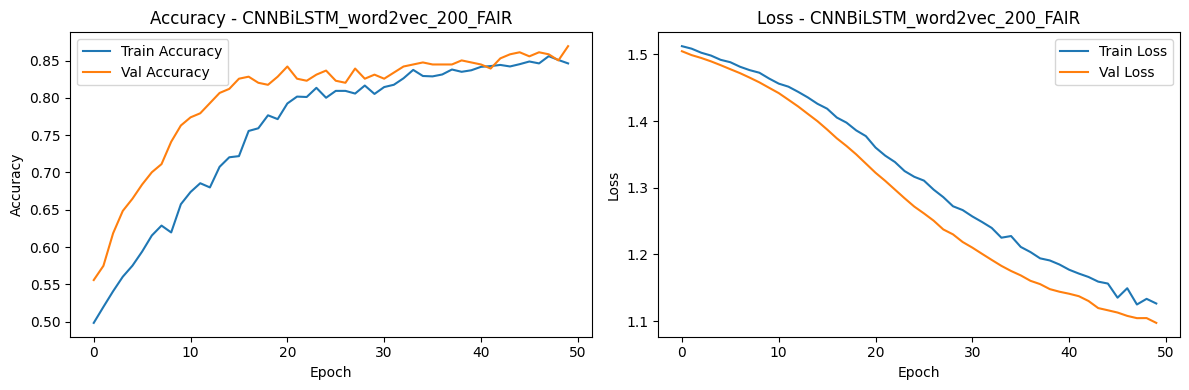

<Figure size 600x400 with 0 Axes>

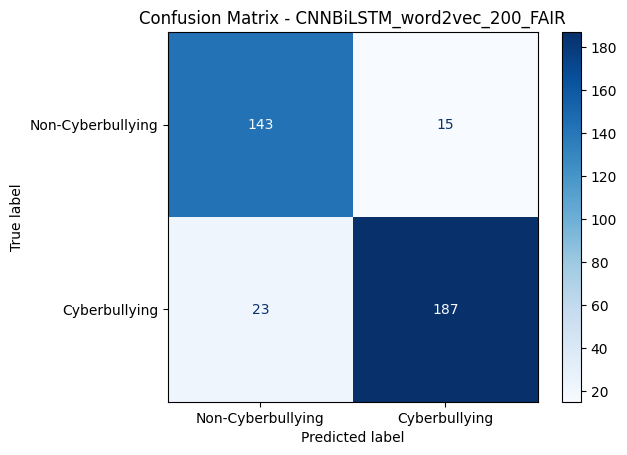

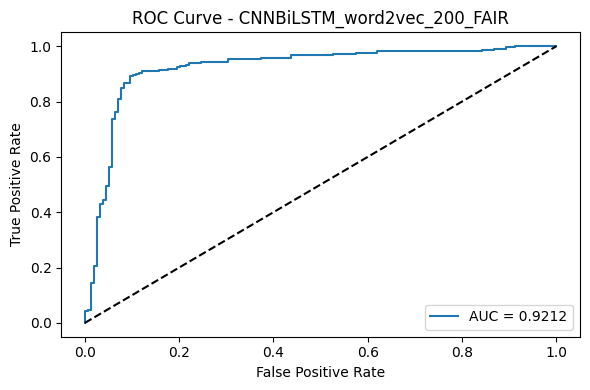

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.86      0.91      0.88       158
    Cyberbullying       0.93      0.89      0.91       210

         accuracy                           0.90       368
        macro avg       0.89      0.90      0.90       368
     weighted avg       0.90      0.90      0.90       368


✅ Accuracy: 0.8967, AUC: 0.9212, Precision: 0.9257, Recall: 0.8905, F1: 0.9078

📌 Training model: WORD2VEC 300D
📥 Loading Word2Vec from: /content/word2vec_id_300.bin

📌 Contoh kata dari WORD2VEC 300D:
bahagia: [ 0.5970874   0.23316179 -1.8253582   0.49190953  0.14741221]...
enggak: [ 0.40246898  0.48063082  0.16330013  0.27038163 -0.36251777]...
semangat: [ 1.3836067  1.4520692 -0.2636651  0.9100558 -1.3043724]...
tolol: [ 0.05049336  0.24414721  0.0628707  -0.09545443  0.0162457 ]...
norak: [ 0.27043355  0.5608446  -0.00645342  0.08702045 -0.18679622]...
banget: [ 0.21274483  1.405991    0.43252915  0.2991186

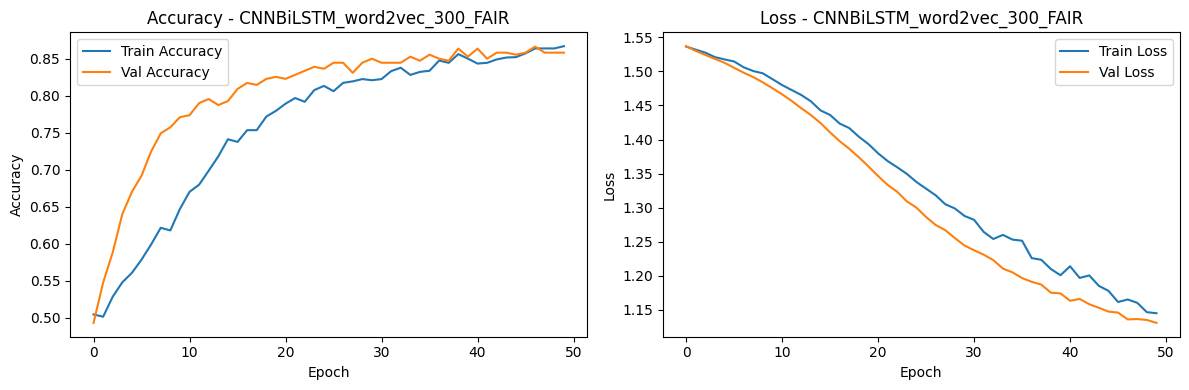

<Figure size 600x400 with 0 Axes>

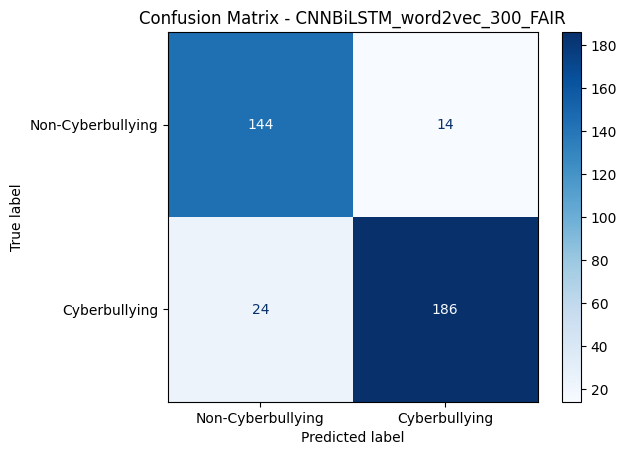

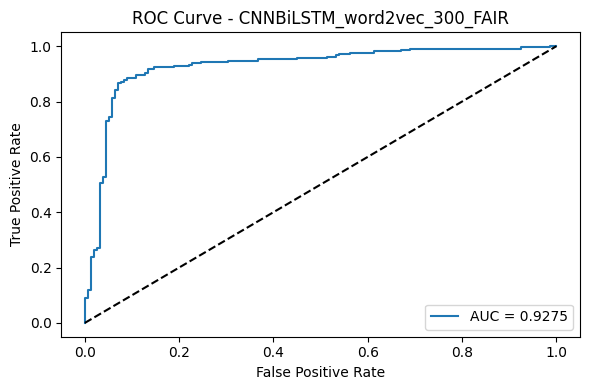

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.86      0.91      0.88       158
    Cyberbullying       0.93      0.89      0.91       210

         accuracy                           0.90       368
        macro avg       0.89      0.90      0.90       368
     weighted avg       0.90      0.90      0.90       368


✅ Accuracy: 0.8967, AUC: 0.9275, Precision: 0.93, Recall: 0.8857, F1: 0.9073

📌 Training model: FASTTEXT 300D
📥 Loading FastText from: /content/drive/MyDrive/resources/cc.id.300.bin

📌 Contoh kata dari FASTTEXT 300D:
oov: [0.06179348 0.02740367 0.03621004 0.03203738 0.01887132]...
bahagia: [-0.00831283 -0.10030977 -0.02840042  0.06064843 -0.04130146]...
enggak: [-0.01656171  0.00548528  0.04379252  0.06003596 -0.02881695]...
semangat: [-0.05048427 -0.039581   -0.02468412  0.00075645 -0.04007722]...
tolol: [ 0.06908239  0.02892014 -0.0007012   0.08941144 -0.01374871]...
norak: [ 0.07936431  0.01482968 -0.078910

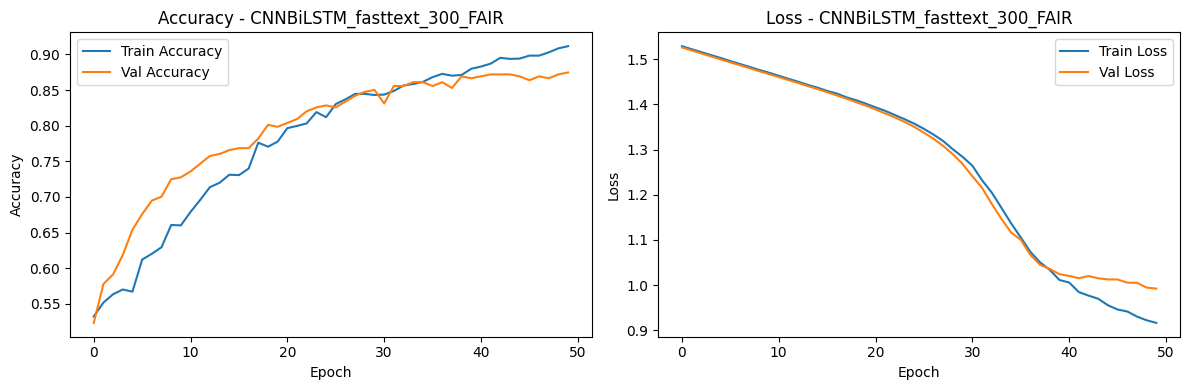

<Figure size 600x400 with 0 Axes>

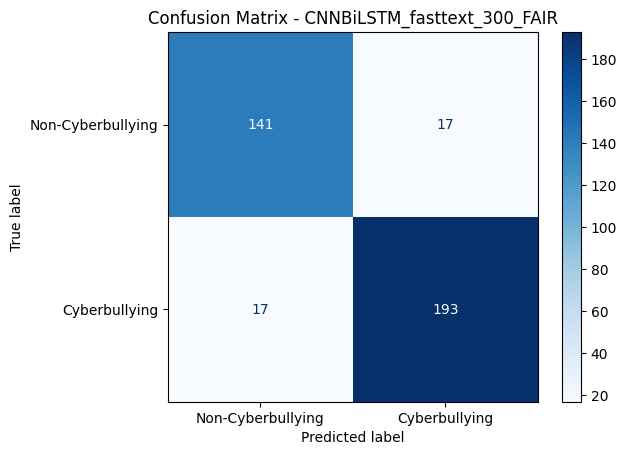

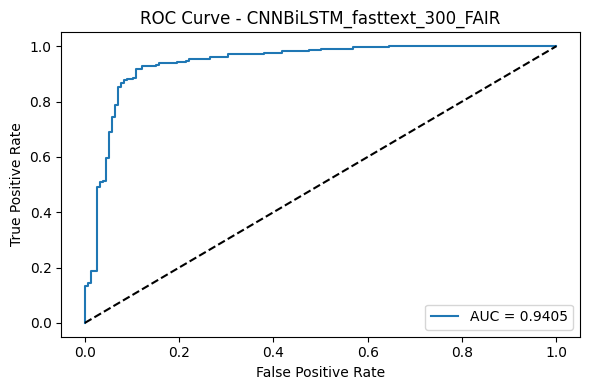

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.89      0.89      0.89       158
    Cyberbullying       0.92      0.92      0.92       210

         accuracy                           0.91       368
        macro avg       0.91      0.91      0.91       368
     weighted avg       0.91      0.91      0.91       368


✅ Accuracy: 0.9076, AUC: 0.9405, Precision: 0.919, Recall: 0.919, F1: 0.919
✅ Model dan tokenizer FastText berhasil disimpan!


In [ ]:
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    roc_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
from keras.layers import Input, Embedding, Dropout, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE

# Daftar embedding
embedding_types = ['glove', 'word2vec', 'fasttext']
word2vec_dims = [50, 100, 200, 300]
accuracy_results_cnn_bilstm = {}

# Loop semua embedding dan dimensi
for embedding_type in embedding_types:
    dims = [300] if embedding_type != 'word2vec' else word2vec_dims
    for dim in dims:
        print(f"\n📌 Training model: {embedding_type.upper()} {dim}D")

        # Load embedding matrix (gunakan fungsi milikmu)
        embedding_matrix = load_embedding_matrix(embedding_type, tokenizer, dim)

        # Split 70:15:15
        X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42)

        # SMOTE
        X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

        # CNN–BiLSTM model
        inp = Input(shape=(max_len,))
        x = Embedding(input_dim=vocab_size, output_dim=dim, weights=[embedding_matrix], trainable=True)(inp)
        x = Dropout(0.3)(x)
        x = Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = MaxPooling1D(pool_size=2)(x)
        x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
        x = Dropout(0.3)(x)
        x = Bidirectional(LSTM(32, kernel_regularizer=l2(0.001)))(x)
        x = Dropout(0.3)(x)
        x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = Dropout(0.3)(x)
        out = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inp, outputs=out)
        model.compile(loss='binary_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy', 'AUC'])

        # Training
        early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
        history = model.fit(
            X_resampled, y_resampled,
            epochs=50,
            batch_size=64,
            validation_data=(X_val, y_val),
            callbacks=[early_stop],
            verbose=0
        )

        # Evaluation
        y_proba = model.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        optimal_idx = (tpr - fpr).argmax()
        optimal_threshold = thresholds[optimal_idx]
        print(f"\n✅ Optimal Threshold (ROC): {optimal_threshold:.4f}")

        y_pred = (y_proba >= optimal_threshold).astype("int32")

        acc = round(accuracy_score(y_test, y_pred), 4)
        auc = round(roc_auc_score(y_test, y_proba), 4)
        precision = round(precision_score(y_test, y_pred), 4)
        recall = round(recall_score(y_test, y_pred), 4)
        f1 = round(f1_score(y_test, y_pred), 4)

        model_key = f"CNNBiLSTM_{embedding_type}_{dim}_FAIR"
        accuracy_results_cnn_bilstm[model_key] = {
            'val_acc': acc,
            'auc': auc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

        # Grafik Accuracy & Loss
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title(f"Accuracy - {model_key}")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f"Loss - {model_key}")
        plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
        plt.tight_layout()
        plt.show()

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Cyberbullying", "Cyberbullying"])
        plt.figure(figsize=(6, 4))
        disp.plot(cmap="Blues", values_format="d")
        plt.title(f"Confusion Matrix - {model_key}")
        plt.show()

        # ROC Curve
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f"AUC = {auc}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
        plt.title(f"ROC Curve - {model_key}")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Classification Report
        print("📄 Classification Report:")
        print(classification_report(y_test, y_pred, target_names=["Non-Cyberbullying", "Cyberbullying"]))
        print(f"\n✅ Accuracy: {acc}, AUC: {auc}, Precision: {precision}, Recall: {recall}, F1: {f1}")

        # === SIMPAN MODEL & TOKENIZER KHUSUS FASTTEXT 300D ===
        if embedding_type == 'fasttext' and dim == 300:
            model.save("CNNBiLSTM_fasttext_300_FAIR.h5")
            with open("tokenizer_fasttext.pkl", "wb") as f:
                pickle.dump(tokenizer, f)
            print("✅ Model dan tokenizer FastText berhasil disimpan!")


In [ ]:
# Buat DataFrame dari hasil
df_cnn_bilstm = pd.DataFrame([
    {
        'Model': name,
        'Validation Accuracy': val['val_acc'],
        'AUC': val['auc'],
        'Precision': val['precision'],
        'Recall': val['recall'],
        'F1-Score': val['f1']
    }
    for name, val in accuracy_results_cnn_bilstm.items()
])

# Urutkan berdasarkan Accuracy dan AUC
df_cnn_bilstm = df_cnn_bilstm.sort_values(by=['Validation Accuracy', 'AUC'], ascending=False).reset_index(drop=True)

# Tampilkan hasil
df_cnn_bilstm

Model  Validation Accuracy     AUC  Precision  \
0  CNNBiLSTM_fasttext_300_FAIR               0.9130  0.9410     0.9238   
1  CNNBiLSTM_word2vec_300_FAIR               0.9049  0.9248     0.9187   
2     CNNBiLSTM_glove_300_FAIR               0.9022  0.9377     0.9223   
3  CNNBiLSTM_word2vec_100_FAIR               0.8750  0.9064     0.8868   
4  CNNBiLSTM_word2vec_200_FAIR               0.8750  0.9033     0.9184   
5   CNNBiLSTM_word2vec_50_FAIR               0.8424  0.8860     0.8918   

   Recall  F1-Score  
0  0.9238    0.9238  
1  0.9143    0.9165  
2  0.9048    0.9135  
3  0.8952    0.8910  
4  0.8571    0.8867  
5  0.8238    0.8564

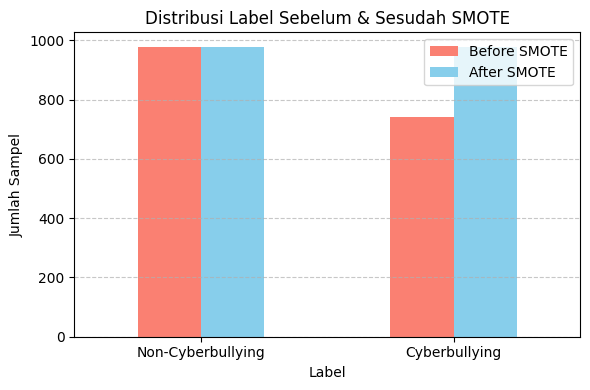

In [ ]:
# Mapping label numerik ke label teks
label_map = {1: "Non-Cyberbullying", 0: "Cyberbullying"}

# Buat DataFrame distribusi
df_dist = pd.DataFrame({
    'Before SMOTE': pd.Series(y_train).value_counts().rename(index=label_map),
    'After SMOTE': pd.Series(y_resampled).value_counts().rename(index=label_map)
})

# Plot
df_dist.plot(kind='bar', rot=0, figsize=(6,4), color=['salmon', 'skyblue'])
plt.title("Distribusi Label Sebelum & Sesudah SMOTE")
plt.xlabel("Label")
plt.ylabel("Jumlah Sampel")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Bi-LSTM


📌 Training Bi-LSTM: FASTTEXT 300D
📥 Loading FastText from: /content/drive/MyDrive/resources/cc.id.300.bin

📌 Contoh kata dari FASTTEXT 300D:
oov: [0.06179348 0.02740367 0.03621004 0.03203738 0.01887132]...
bahagia: [-0.00831283 -0.10030977 -0.02840042  0.06064843 -0.04130146]...
enggak: [-0.01656171  0.00548528  0.04379252  0.06003596 -0.02881695]...
semangat: [-0.05048427 -0.039581   -0.02468412  0.00075645 -0.04007722]...
tolol: [ 0.06908239  0.02892014 -0.0007012   0.08941144 -0.01374871]...
norak: [ 0.07936431  0.01482968 -0.07891081  0.01746366  0.01150789]...
banget: [ 0.00823963 -0.03834731  0.00525844  0.03335897 -0.05812761]...
orang: [ 0.04398865 -0.03032926 -0.01770458  0.12002504 -0.08117092]...
aku: [ 0.01258465 -0.05965358  0.09049556  0.29484874  0.02158902]...
sama: [ 0.07707722  0.0165033   0.05018882  0.06665502 -0.01466809]...

🔍 Total kata dalam tokenizer: 6098
🚫 Jumlah kata OOV: 0

🧠 Diagnostik kata penting:
'tolol': [ 0.06908239  0.02892014 -0.0007012   0.0894114

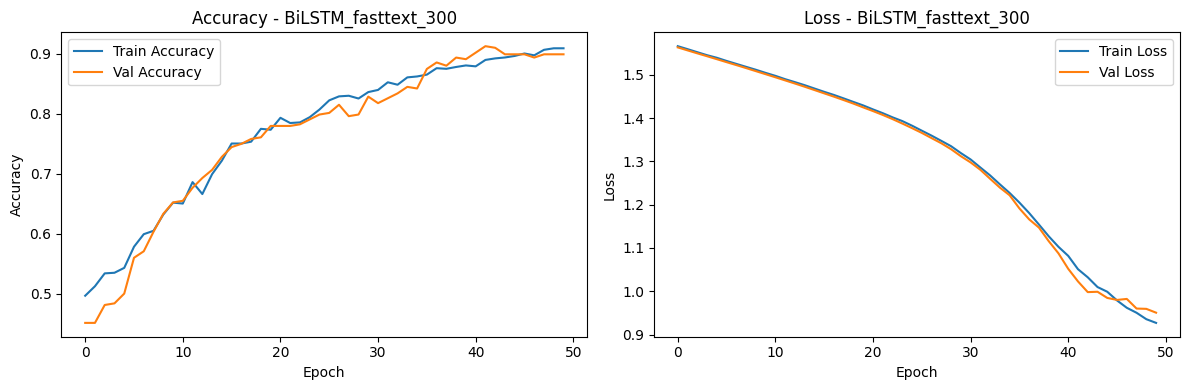

<Figure size 600x400 with 0 Axes>

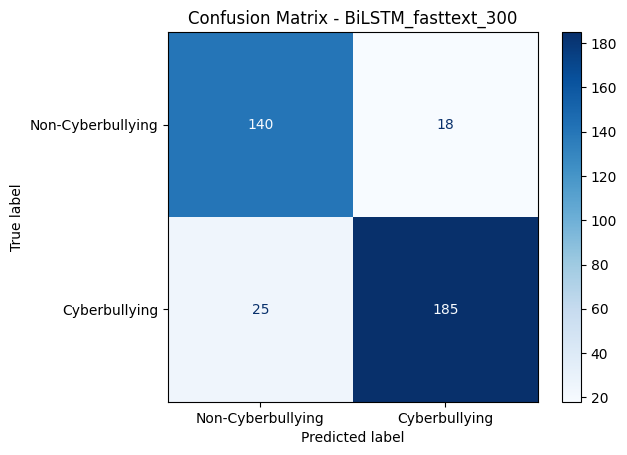

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.85      0.89      0.87       158
    Cyberbullying       0.91      0.88      0.90       210

         accuracy                           0.88       368
        macro avg       0.88      0.88      0.88       368
     weighted avg       0.88      0.88      0.88       368


📌 Training Bi-LSTM: GLOVE 300D
📥 Loading GloVe from: /content/glove_id.txt

📌 Contoh kata dari GLOVE 300D:
bahagia: [-0.00831283 -0.10030977 -0.02840042  0.06064843 -0.04130146]...
enggak: [-0.01656171  0.00548528  0.04379252  0.06003596 -0.02881695]...
semangat: [-0.05048427 -0.039581   -0.02468412  0.00075645 -0.04007722]...
tolol: [ 0.06908239  0.02892014 -0.0007012   0.08941144 -0.01374871]...
norak: [ 0.07936431  0.01482968 -0.07891081  0.01746366  0.01150789]...
banget: [ 0.00823963 -0.03834731  0.00525844  0.03335897 -0.05812761]...
orang: [ 0.04398865 -0.03032926 -0.01770458  0.12002504 -0.08117092]...

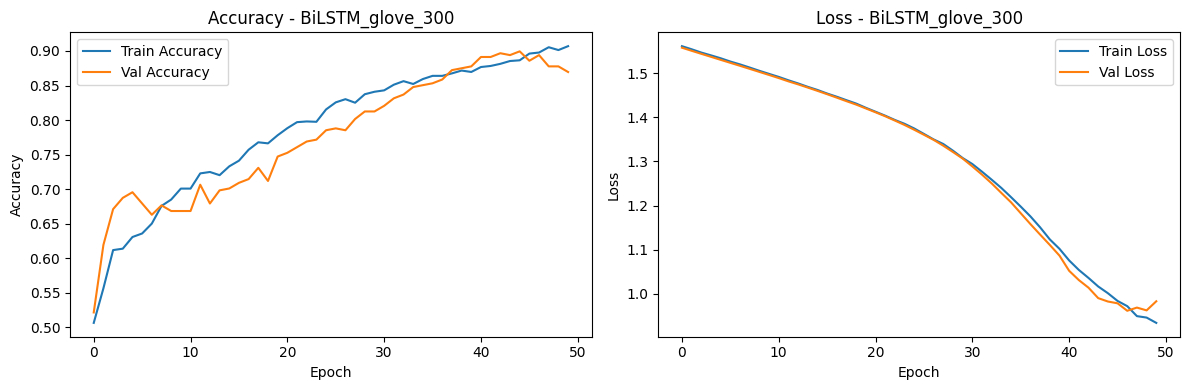

<Figure size 600x400 with 0 Axes>

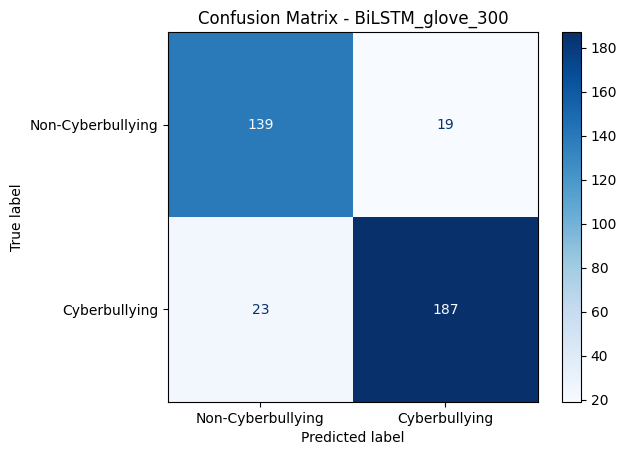

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.86      0.88      0.87       158
    Cyberbullying       0.91      0.89      0.90       210

         accuracy                           0.89       368
        macro avg       0.88      0.89      0.88       368
     weighted avg       0.89      0.89      0.89       368


📌 Training Bi-LSTM: WORD2VEC 50D
📥 Loading Word2Vec from: /content/word2vec_id_50.bin

📌 Contoh kata dari WORD2VEC 50D:
bahagia: [-0.3022337  -2.8686457   1.7559555  -0.19663954  2.0469792 ]...
enggak: [ 0.15940285  0.41729936 -0.15476291 -0.569298    0.39537793]...
semangat: [-0.8418674 -5.7455716  2.903861   3.5248647  5.0374784]...
tolol: [-0.06165906  0.23464917 -0.02727623 -0.1659689  -0.10045199]...
norak: [-0.43134305  0.6263856  -0.24761565 -0.4325252   0.698999  ]...
banget: [-0.3524352   0.7922002  -0.45961514 -1.5537024   0.44823644]...
orang: [ 0.08901376 -5.1848483   3.6989958   6.164505    1.2454

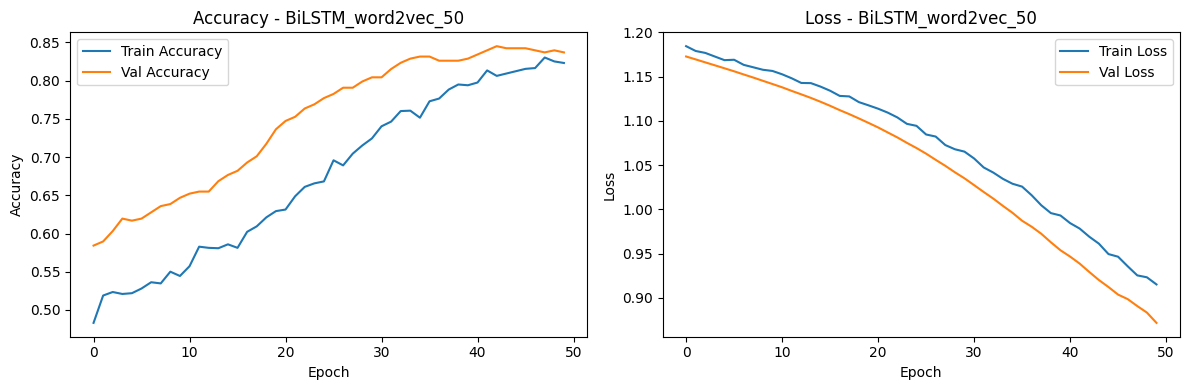

<Figure size 600x400 with 0 Axes>

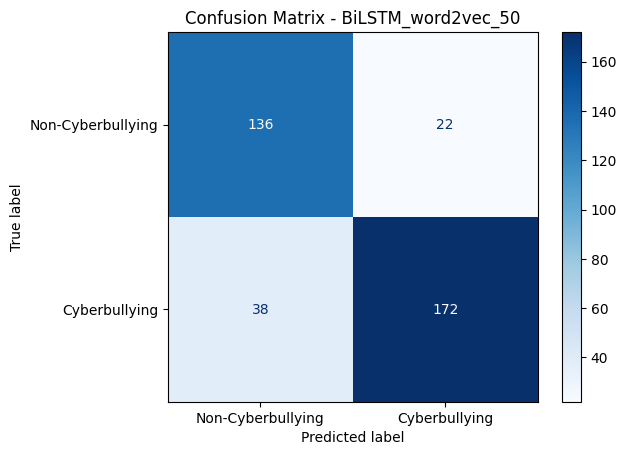

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.78      0.86      0.82       158
    Cyberbullying       0.89      0.82      0.85       210

         accuracy                           0.84       368
        macro avg       0.83      0.84      0.84       368
     weighted avg       0.84      0.84      0.84       368


📌 Training Bi-LSTM: WORD2VEC 100D
📥 Loading Word2Vec from: /content/word2vec_id_100.bin

📌 Contoh kata dari WORD2VEC 100D:
bahagia: [ 3.1437027   0.537713   -1.6531277   0.92803085 -2.687515  ]...
enggak: [ 0.10905608  0.1304144  -0.26440609  0.33538952  0.36660677]...
semangat: [ 0.6373883  5.383101  -0.8477804  2.511306  -2.2876105]...
tolol: [ 0.00778567  0.01447748  0.08213059 -0.10732719 -0.11331836]...
norak: [ 0.16107692 -0.22466183 -0.43016976  0.22252126 -0.02939209]...
banget: [-0.20109758  0.25081342 -0.1920552   1.8164932   1.0989629 ]...
orang: [ 1.439967   3.062194   2.6841261  2.917476  -4.08261

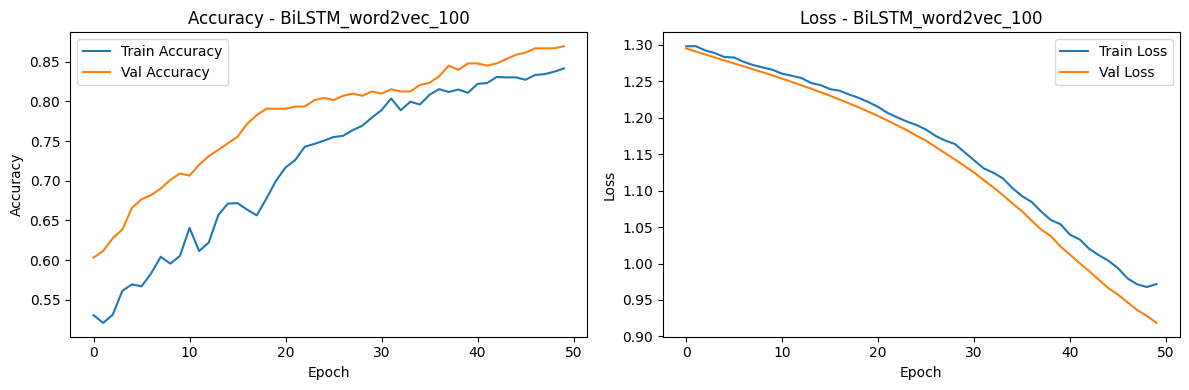

<Figure size 600x400 with 0 Axes>

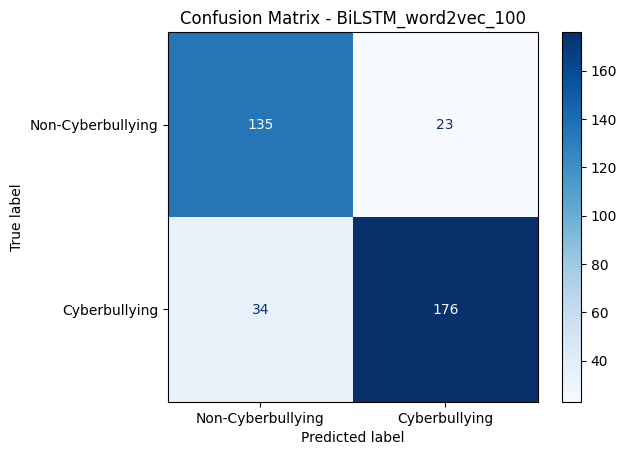

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.80      0.85      0.83       158
    Cyberbullying       0.88      0.84      0.86       210

         accuracy                           0.85       368
        macro avg       0.84      0.85      0.84       368
     weighted avg       0.85      0.85      0.85       368


📌 Training Bi-LSTM: WORD2VEC 200D
📥 Loading Word2Vec from: /content/word2vec_id_200.bin

📌 Contoh kata dari WORD2VEC 200D:
bahagia: [ 2.934587   0.9318231 -1.246909   2.723685   1.2342818]...
enggak: [-0.05801967 -0.22771855 -0.88626504  1.1990705  -0.17378625]...
semangat: [ 1.3123378   0.94009113  1.1164782  -0.3647796   0.78177804]...
tolol: [ 0.09252032 -0.0524863  -0.22170584  0.51463574  0.12622167]...
norak: [ 0.7797513  -0.1558454  -0.45329452  0.8955188  -0.46652147]...
banget: [ 0.6252212  -0.49087802 -2.0690768   1.7529353  -0.09093203]...
orang: [1.1288401  0.18045494 2.4223437  0.3836807  1.189997

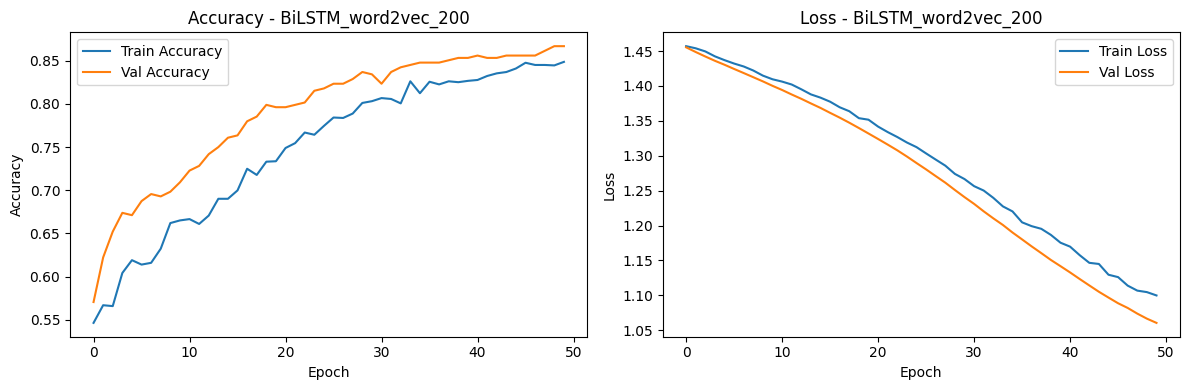

<Figure size 600x400 with 0 Axes>

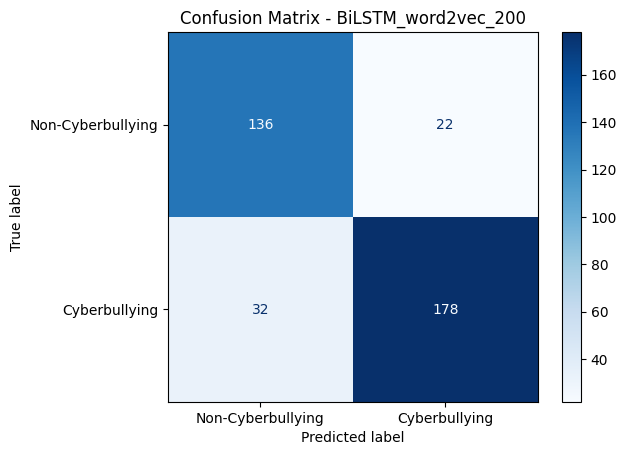

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.81      0.86      0.83       158
    Cyberbullying       0.89      0.85      0.87       210

         accuracy                           0.85       368
        macro avg       0.85      0.85      0.85       368
     weighted avg       0.86      0.85      0.85       368


📌 Training Bi-LSTM: WORD2VEC 300D
📥 Loading Word2Vec from: /content/word2vec_id_300.bin

📌 Contoh kata dari WORD2VEC 300D:
bahagia: [ 1.1892209  1.0122477 -1.5196415  1.2461632 -2.5674062]...
enggak: [ 0.26331678  0.46014997  0.06069694  0.22554784 -0.46962708]...
semangat: [ 4.2209387  2.0135    -1.0294335  1.7380211 -1.9866049]...
tolol: [ 0.35378474  0.09190788 -0.04850911  0.01066863 -0.09223795]...
norak: [ 0.45710734  0.55222183 -0.269511    0.38458169 -0.2852784 ]...
banget: [ 0.17700985  1.4922363  -0.15857759  0.4049496  -0.7657361 ]...
orang: [ 3.4871535  -0.23594941  0.8692075   1.654903    1.652548

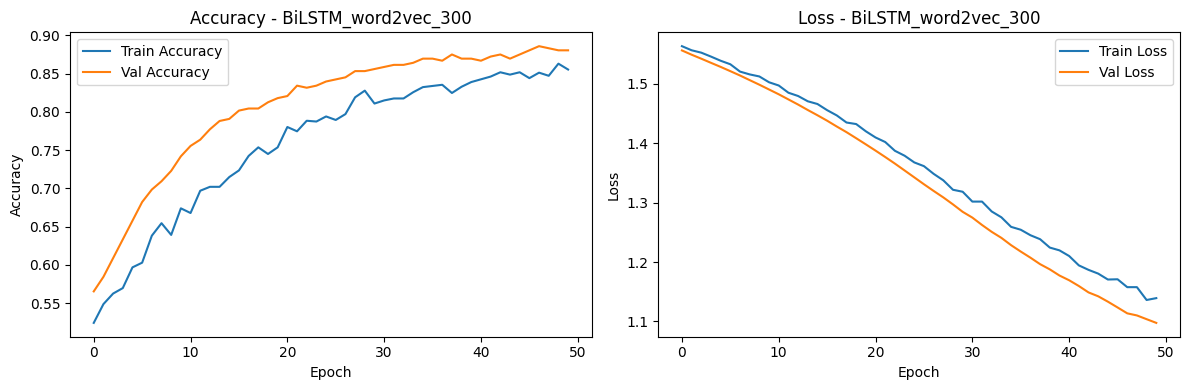

<Figure size 600x400 with 0 Axes>

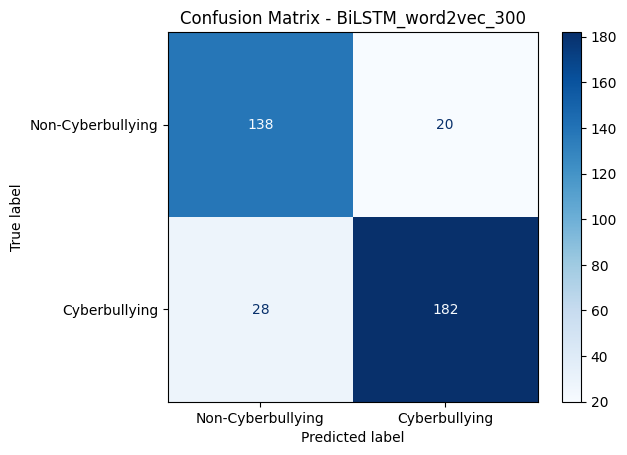

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.83      0.87      0.85       158
    Cyberbullying       0.90      0.87      0.88       210

         accuracy                           0.87       368
        macro avg       0.87      0.87      0.87       368
     weighted avg       0.87      0.87      0.87       368



Model  Validation Accuracy     AUC  Precision  Recall  \
0  BiLSTM_fasttext_300               0.9130  0.9276     0.9113  0.8810   
1     BiLSTM_glove_300               0.8995  0.9307     0.9078  0.8905   
2  BiLSTM_word2vec_300               0.8859  0.9152     0.9010  0.8667   
3  BiLSTM_word2vec_100               0.8696  0.9022     0.8844  0.8381   
4  BiLSTM_word2vec_200               0.8668  0.8975     0.8900  0.8476   
5   BiLSTM_word2vec_50               0.8451  0.8700     0.8866  0.8190   

   F1-Score  
0    0.8959  
1    0.8990  
2    0.8835  
3    0.8606  
4    0.8683  
5    0.8515

In [ ]:
accuracy_results_bilstm = {}

embedding_types = ['fasttext', 'glove', 'word2vec']
word2vec_dims = [50, 100, 200, 300]

for embedding_type in embedding_types:
    dims = [300] if embedding_type != 'word2vec' else word2vec_dims
    for dim in dims:
        print(f"\n📌 Training Bi-LSTM: {embedding_type.upper()} {dim}D")
        embedding_matrix = load_embedding_matrix(embedding_type, tokenizer, dim)

        # Split data
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

        # SMOTE
        X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

        # Bi-LSTM Model
        inp = Input(shape=(max_len,))
        x = Embedding(input_dim=vocab_size, output_dim=dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(inp)
        x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)))(x)
        x = Dropout(0.3)(x)
        x = Bidirectional(LSTM(32, kernel_regularizer=l2(0.001)))(x)
        x = Dropout(0.3)(x)
        x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = Dropout(0.3)(x)
        out = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inp, outputs=out)
        model.compile(loss='binary_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy'])

        # Training
        early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
        history = model.fit(X_resampled, y_resampled, epochs=50, batch_size=64,
                            validation_data=(X_val, y_val), callbacks=[early_stop], verbose=0)

        # Evaluation
        y_proba = model.predict(X_test)
        y_pred = (y_proba > 0.5).astype("int32")

        acc = round(max(history.history['val_accuracy']), 4)
        auc = round(roc_auc_score(y_test, y_proba), 4)
        precision = round(precision_score(y_test, y_pred), 4)
        recall = round(recall_score(y_test, y_pred), 4)
        f1 = round(f1_score(y_test, y_pred), 4)

        print(f"✅ Best Validation Accuracy: {acc}")
        print(f"🟢 AUC Score: {auc}")
        print(f"📌 Precision: {precision} | Recall: {recall} | F1 Score: {f1}")

        model_key = f"BiLSTM_{embedding_type}_{dim}"
        accuracy_results_bilstm[model_key] = {
            'val_acc': acc,
            'auc': auc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

        # === Plot Accuracy & Loss ===
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title(f"Accuracy - {model_key}")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f"Loss - {model_key}")
        plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
        plt.tight_layout()
        plt.show()

        # === Confusion Matrix ===
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Cyberbullying", "Cyberbullying"])
        plt.figure(figsize=(6, 4))
        disp.plot(cmap="Blues", values_format="d")
        plt.title(f"Confusion Matrix - {model_key}")
        plt.show()

        # Classification Report
        print("📄 Classification Report:")
        print(classification_report(y_test, y_pred, target_names=["Non-Cyberbullying", "Cyberbullying"]))

# Buat DataFrame dari hasil
df_bilstm = pd.DataFrame([
    {
        'Model': name,
        'Validation Accuracy': val['val_acc'],
        'AUC': val['auc'],
        'Precision': val['precision'],
        'Recall': val['recall'],
        'F1-Score': val['f1']
    }
    for name, val in accuracy_results_bilstm.items()
])

# Urutkan berdasarkan Accuracy dan AUC
df_bilstm = df_bilstm.sort_values(by=['Validation Accuracy', 'AUC'], ascending=False).reset_index(drop=True)

# Tampilkan hasil
df_bilstm


# LSTM


📌 Training LSTM: FASTTEXT 300D
📥 Loading FastText from: /content/drive/MyDrive/resources/cc.id.300.bin

📌 Contoh kata dari FASTTEXT 300D:
oov: [0.06179348 0.02740367 0.03621004 0.03203738 0.01887132]...
bahagia: [-0.00831283 -0.10030977 -0.02840042  0.06064843 -0.04130146]...
enggak: [-0.01656171  0.00548528  0.04379252  0.06003596 -0.02881695]...
semangat: [-0.05048427 -0.039581   -0.02468412  0.00075645 -0.04007722]...
tolol: [ 0.06908239  0.02892014 -0.0007012   0.08941144 -0.01374871]...
norak: [ 0.07936431  0.01482968 -0.07891081  0.01746366  0.01150789]...
banget: [ 0.00823963 -0.03834731  0.00525844  0.03335897 -0.05812761]...
orang: [ 0.04398865 -0.03032926 -0.01770458  0.12002504 -0.08117092]...
aku: [ 0.01258465 -0.05965358  0.09049556  0.29484874  0.02158902]...
sama: [ 0.07707722  0.0165033   0.05018882  0.06665502 -0.01466809]...

🔍 Total kata dalam tokenizer: 6098
🚫 Jumlah kata OOV: 0

🧠 Diagnostik kata penting:
'tolol': [ 0.06908239  0.02892014 -0.0007012   0.08941144 -

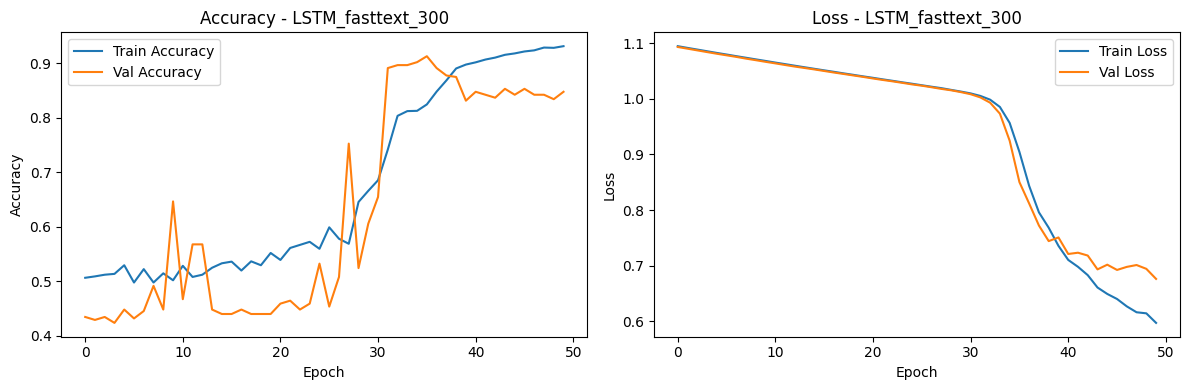

<Figure size 600x400 with 0 Axes>

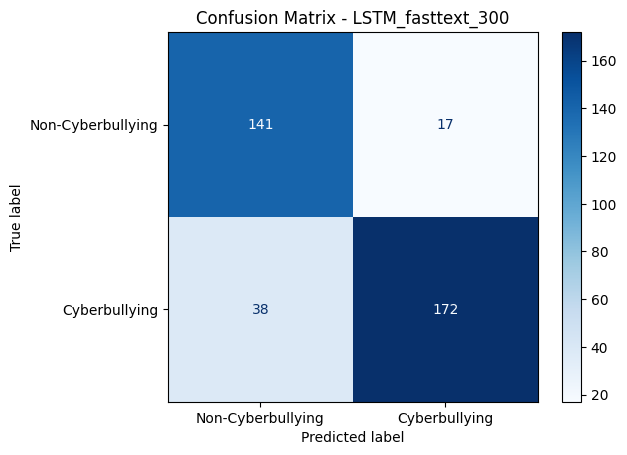

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.79      0.89      0.84       158
    Cyberbullying       0.91      0.82      0.86       210

         accuracy                           0.85       368
        macro avg       0.85      0.86      0.85       368
     weighted avg       0.86      0.85      0.85       368


📌 Training LSTM: GLOVE 300D
📥 Loading GloVe from: /content/glove_id.txt

📌 Contoh kata dari GLOVE 300D:
bahagia: [-0.00831283 -0.10030977 -0.02840042  0.06064843 -0.04130146]...
enggak: [-0.01656171  0.00548528  0.04379252  0.06003596 -0.02881695]...
semangat: [-0.05048427 -0.039581   -0.02468412  0.00075645 -0.04007722]...
tolol: [ 0.06908239  0.02892014 -0.0007012   0.08941144 -0.01374871]...
norak: [ 0.07936431  0.01482968 -0.07891081  0.01746366  0.01150789]...
banget: [ 0.00823963 -0.03834731  0.00525844  0.03335897 -0.05812761]...
orang: [ 0.04398865 -0.03032926 -0.01770458  0.12002504 -0.08117092]...
ak

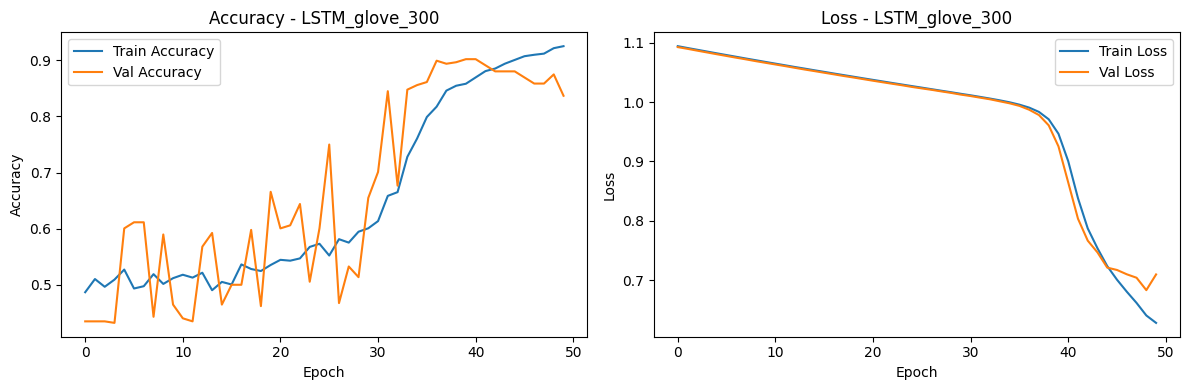

<Figure size 600x400 with 0 Axes>

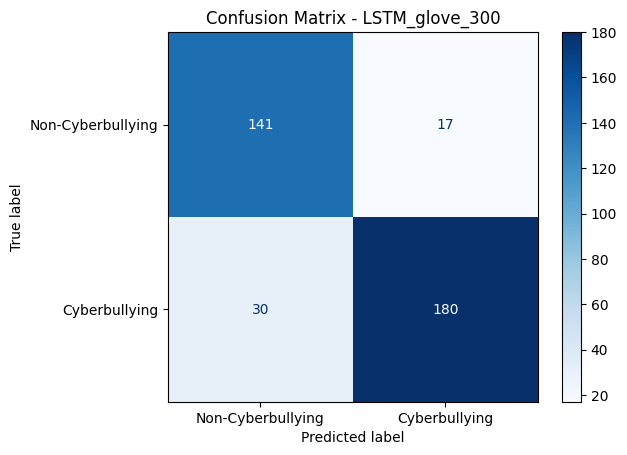

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.82      0.89      0.86       158
    Cyberbullying       0.91      0.86      0.88       210

         accuracy                           0.87       368
        macro avg       0.87      0.87      0.87       368
     weighted avg       0.88      0.87      0.87       368


📌 Training LSTM: WORD2VEC 50D
📥 Loading Word2Vec from: /content/word2vec_id_50.bin

📌 Contoh kata dari WORD2VEC 50D:
bahagia: [-0.3022337  -2.8686457   1.7559555  -0.19663954  2.0469792 ]...
enggak: [ 0.15940285  0.41729936 -0.15476291 -0.569298    0.39537793]...
semangat: [-0.8418674 -5.7455716  2.903861   3.5248647  5.0374784]...
tolol: [-0.06165906  0.23464917 -0.02727623 -0.1659689  -0.10045199]...
norak: [-0.43134305  0.6263856  -0.24761565 -0.4325252   0.698999  ]...
banget: [-0.3524352   0.7922002  -0.45961514 -1.5537024   0.44823644]...
orang: [ 0.08901376 -5.1848483   3.6989958   6.164505    1.2454693

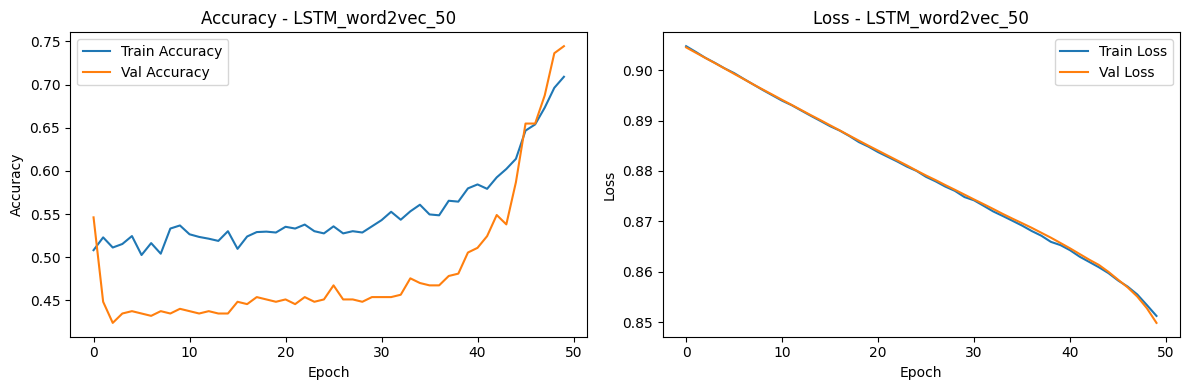

<Figure size 600x400 with 0 Axes>

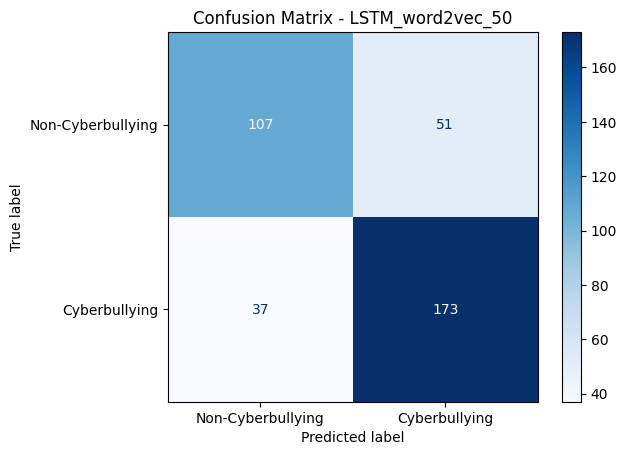

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.74      0.68      0.71       158
    Cyberbullying       0.77      0.82      0.80       210

         accuracy                           0.76       368
        macro avg       0.76      0.75      0.75       368
     weighted avg       0.76      0.76      0.76       368


📌 Training LSTM: WORD2VEC 100D
📥 Loading Word2Vec from: /content/word2vec_id_100.bin

📌 Contoh kata dari WORD2VEC 100D:
bahagia: [ 3.1437027   0.537713   -1.6531277   0.92803085 -2.687515  ]...
enggak: [ 0.10905608  0.1304144  -0.26440609  0.33538952  0.36660677]...
semangat: [ 0.6373883  5.383101  -0.8477804  2.511306  -2.2876105]...
tolol: [ 0.00778567  0.01447748  0.08213059 -0.10732719 -0.11331836]...
norak: [ 0.16107692 -0.22466183 -0.43016976  0.22252126 -0.02939209]...
banget: [-0.20109758  0.25081342 -0.1920552   1.8164932   1.0989629 ]...
orang: [ 1.439967   3.062194   2.6841261  2.917476  -4.08261  ]

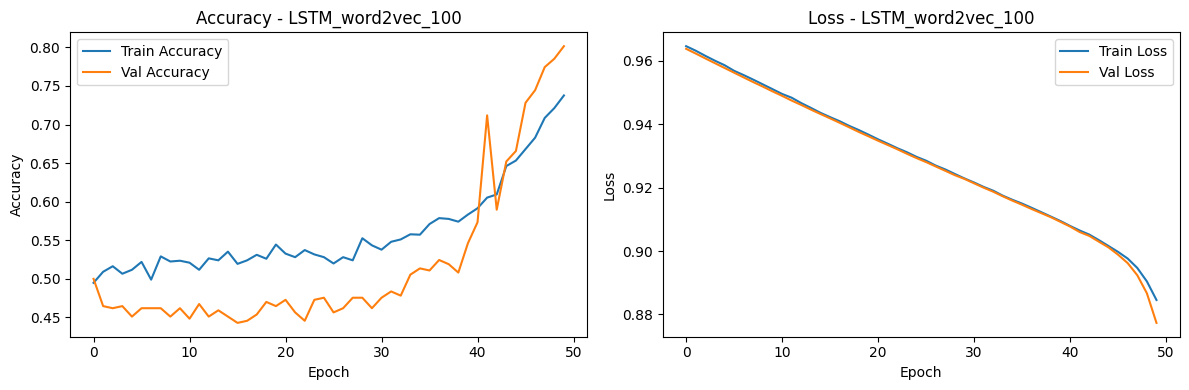

<Figure size 600x400 with 0 Axes>

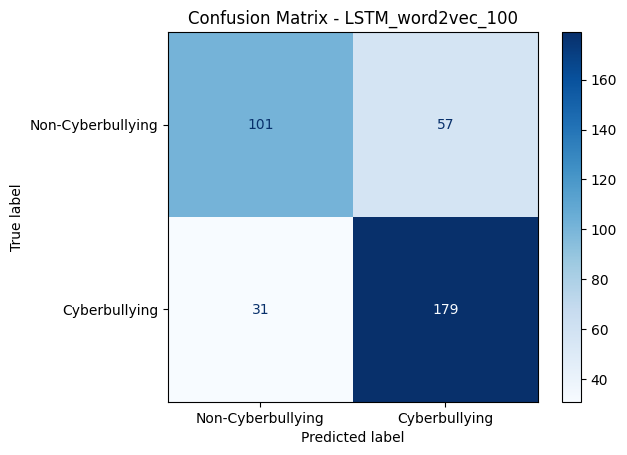

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.77      0.64      0.70       158
    Cyberbullying       0.76      0.85      0.80       210

         accuracy                           0.76       368
        macro avg       0.76      0.75      0.75       368
     weighted avg       0.76      0.76      0.76       368


📌 Training LSTM: WORD2VEC 200D
📥 Loading Word2Vec from: /content/word2vec_id_200.bin

📌 Contoh kata dari WORD2VEC 200D:
bahagia: [ 2.934587   0.9318231 -1.246909   2.723685   1.2342818]...
enggak: [-0.05801967 -0.22771855 -0.88626504  1.1990705  -0.17378625]...
semangat: [ 1.3123378   0.94009113  1.1164782  -0.3647796   0.78177804]...
tolol: [ 0.09252032 -0.0524863  -0.22170584  0.51463574  0.12622167]...
norak: [ 0.7797513  -0.1558454  -0.45329452  0.8955188  -0.46652147]...
banget: [ 0.6252212  -0.49087802 -2.0690768   1.7529353  -0.09093203]...
orang: [1.1288401  0.18045494 2.4223437  0.3836807  1.1899974 ]

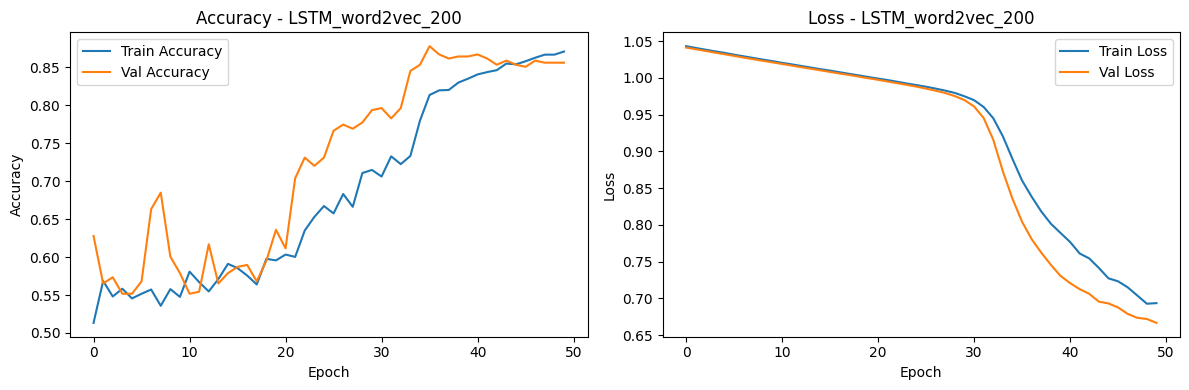

<Figure size 600x400 with 0 Axes>

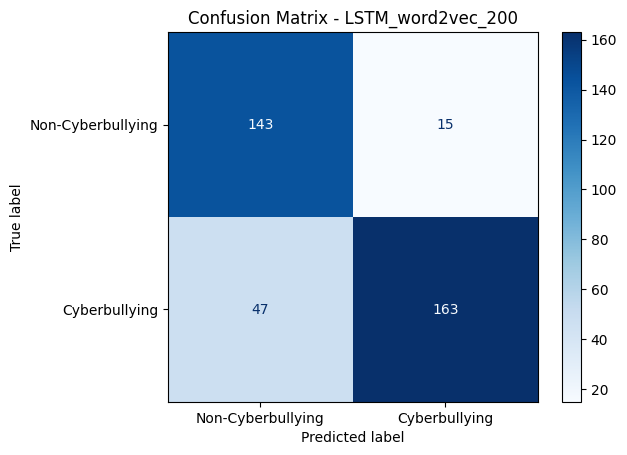

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.75      0.91      0.82       158
    Cyberbullying       0.92      0.78      0.84       210

         accuracy                           0.83       368
        macro avg       0.83      0.84      0.83       368
     weighted avg       0.85      0.83      0.83       368


📌 Training LSTM: WORD2VEC 300D
📥 Loading Word2Vec from: /content/word2vec_id_300.bin

📌 Contoh kata dari WORD2VEC 300D:
bahagia: [ 1.1892209  1.0122477 -1.5196415  1.2461632 -2.5674062]...
enggak: [ 0.26331678  0.46014997  0.06069694  0.22554784 -0.46962708]...
semangat: [ 4.2209387  2.0135    -1.0294335  1.7380211 -1.9866049]...
tolol: [ 0.35378474  0.09190788 -0.04850911  0.01066863 -0.09223795]...
norak: [ 0.45710734  0.55222183 -0.269511    0.38458169 -0.2852784 ]...
banget: [ 0.17700985  1.4922363  -0.15857759  0.4049496  -0.7657361 ]...
orang: [ 3.4871535  -0.23594941  0.8692075   1.654903    1.6525487 ]

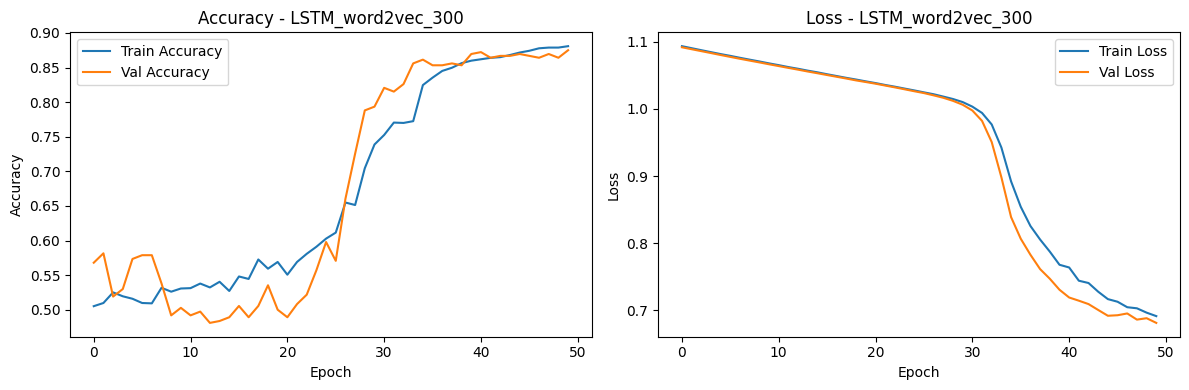

<Figure size 600x400 with 0 Axes>

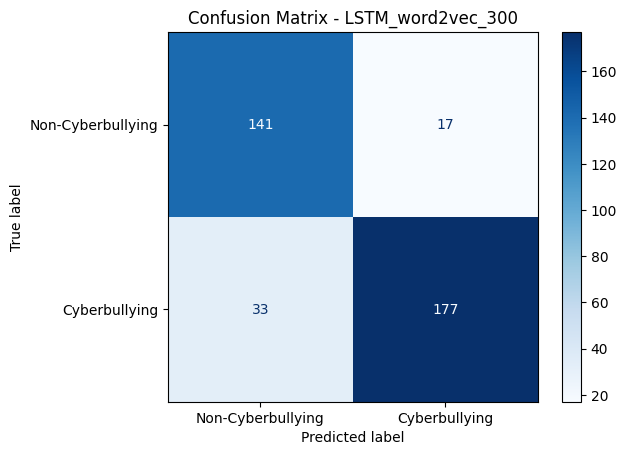

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.81      0.89      0.85       158
    Cyberbullying       0.91      0.84      0.88       210

         accuracy                           0.86       368
        macro avg       0.86      0.87      0.86       368
     weighted avg       0.87      0.86      0.86       368



Model  Validation Accuracy     AUC  Precision  Recall  F1-Score
0  LSTM_fasttext_300               0.9130  0.9250     0.9101  0.8190    0.8622
1     LSTM_glove_300               0.9022  0.9242     0.9137  0.8571    0.8845
2  LSTM_word2vec_200               0.8777  0.9092     0.9157  0.7762    0.8402
3  LSTM_word2vec_300               0.8750  0.9191     0.9124  0.8429    0.8762
4  LSTM_word2vec_100               0.8016  0.7776     0.7585  0.8524    0.8027
5   LSTM_word2vec_50               0.7446  0.7585     0.7723  0.8238    0.7972

In [ ]:
accuracy_results_lstm = {}

embedding_types = ['fasttext', 'glove', 'word2vec']
word2vec_dims = [50, 100, 200, 300]

for embedding_type in embedding_types:
    dims = [300] if embedding_type != 'word2vec' else word2vec_dims
    for dim in dims:
        print(f"\n📌 Training LSTM: {embedding_type.upper()} {dim}D")
        embedding_matrix = load_embedding_matrix(embedding_type, tokenizer, dim)

        # Split
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

        # SMOTE
        X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

        # LSTM Model
        inp = Input(shape=(max_len,))
        x = Embedding(input_dim=vocab_size, output_dim=dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(inp)
        x = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))(x)
        x = Dropout(0.3)(x)
        x = LSTM(32, kernel_regularizer=l2(0.001))(x)
        x = Dropout(0.3)(x)
        x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = Dropout(0.3)(x)
        out = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inp, outputs=out)
        model.compile(loss='binary_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy'])

        # Train
        early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
        history = model.fit(X_resampled, y_resampled, epochs=50, batch_size=64,
                            validation_data=(X_val, y_val), callbacks=[early_stop], verbose=0)

        # Predict & Evaluate
        y_proba = model.predict(X_test)
        y_pred = (y_proba > 0.5).astype("int32")

        acc = round(max(history.history['val_accuracy']), 4)
        auc = round(roc_auc_score(y_test, y_proba), 4)
        precision = round(precision_score(y_test, y_pred), 4)
        recall = round(recall_score(y_test, y_pred), 4)
        f1 = round(f1_score(y_test, y_pred), 4)

        print(f"✅ Best Validation Accuracy: {acc}")
        print(f"🟢 AUC Score: {auc}")
        print(f"📌 Precision: {precision} | Recall: {recall} | F1 Score: {f1}")

        # Simpan hasil
        model_key = f"LSTM_{embedding_type}_{dim}"
        accuracy_results_lstm[model_key] = {
            'val_acc': acc,
            'auc': auc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

        # === Plot Accuracy & Loss ===
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title(f"Accuracy - {model_key}")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f"Loss - {model_key}")
        plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
        plt.tight_layout()
        plt.show()

        # === Confusion Matrix ===
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Cyberbullying", "Cyberbullying"])
        plt.figure(figsize=(6, 4))
        disp.plot(cmap="Blues", values_format="d")
        plt.title(f"Confusion Matrix - {model_key}")
        plt.show()

        # Classification Report
        print("📄 Classification Report:")
        print(classification_report(y_test, y_pred, target_names=["Non-Cyberbullying", "Cyberbullying"]))

# Buat DataFrame
df_lstm = pd.DataFrame([
    {
        'Model': name,
        'Validation Accuracy': val['val_acc'],
        'AUC': val['auc'],
        'Precision': val['precision'],
        'Recall': val['recall'],
        'F1-Score': val['f1']
    }
    for name, val in accuracy_results_lstm.items()
])

# Urutkan berdasarkan akurasi dan AUC tertinggi
df_lstm = df_lstm.sort_values(by=['Validation Accuracy', 'AUC'], ascending=False).reset_index(drop=True)

# Tampilkan DataFrame
df_lstm


# CNN


📌 Training CNN: FASTTEXT 300D
📥 Loading FastText from: /content/drive/MyDrive/resources/cc.id.300.bin

📌 Contoh kata dari FASTTEXT 300D:
oov: [0.06179348 0.02740367 0.03621004 0.03203738 0.01887132]...
bahagia: [-0.00831283 -0.10030977 -0.02840042  0.06064843 -0.04130146]...
enggak: [-0.01656171  0.00548528  0.04379252  0.06003596 -0.02881695]...
semangat: [-0.05048427 -0.039581   -0.02468412  0.00075645 -0.04007722]...
tolol: [ 0.06908239  0.02892014 -0.0007012   0.08941144 -0.01374871]...
norak: [ 0.07936431  0.01482968 -0.07891081  0.01746366  0.01150789]...
banget: [ 0.00823963 -0.03834731  0.00525844  0.03335897 -0.05812761]...
orang: [ 0.04398865 -0.03032926 -0.01770458  0.12002504 -0.08117092]...
aku: [ 0.01258465 -0.05965358  0.09049556  0.29484874  0.02158902]...
sama: [ 0.07707722  0.0165033   0.05018882  0.06665502 -0.01466809]...

🔍 Total kata dalam tokenizer: 6098
🚫 Jumlah kata OOV: 0

🧠 Diagnostik kata penting:
'tolol': [ 0.06908239  0.02892014 -0.0007012   0.08941144 -0

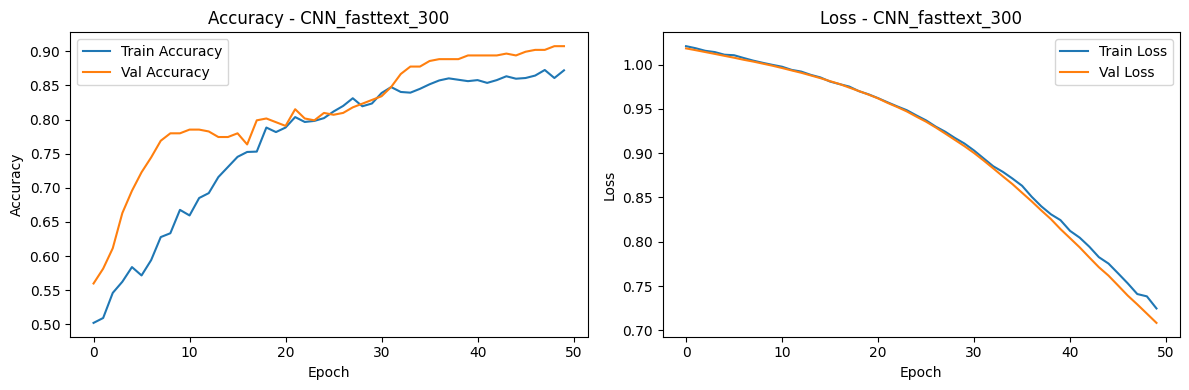

<Figure size 600x400 with 0 Axes>

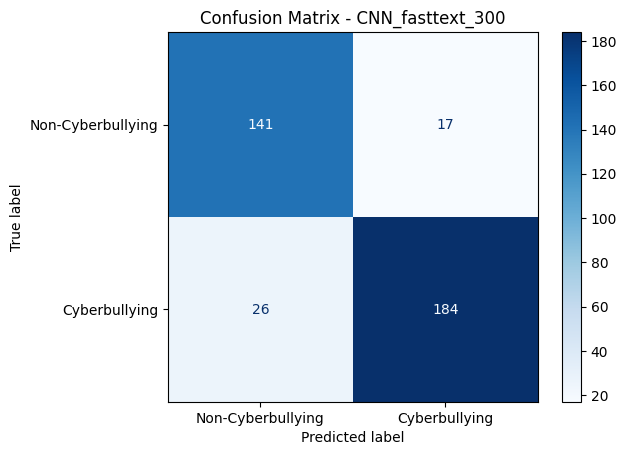

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.84      0.89      0.87       158
    Cyberbullying       0.92      0.88      0.90       210

         accuracy                           0.88       368
        macro avg       0.88      0.88      0.88       368
     weighted avg       0.88      0.88      0.88       368


📌 Training CNN: GLOVE 300D
📥 Loading GloVe from: /content/glove_id.txt

📌 Contoh kata dari GLOVE 300D:
bahagia: [-0.00831283 -0.10030977 -0.02840042  0.06064843 -0.04130146]...
enggak: [-0.01656171  0.00548528  0.04379252  0.06003596 -0.02881695]...
semangat: [-0.05048427 -0.039581   -0.02468412  0.00075645 -0.04007722]...
tolol: [ 0.06908239  0.02892014 -0.0007012   0.08941144 -0.01374871]...
norak: [ 0.07936431  0.01482968 -0.07891081  0.01746366  0.01150789]...
banget: [ 0.00823963 -0.03834731  0.00525844  0.03335897 -0.05812761]...
orang: [ 0.04398865 -0.03032926 -0.01770458  0.12002504 -0.08117092]...
aku

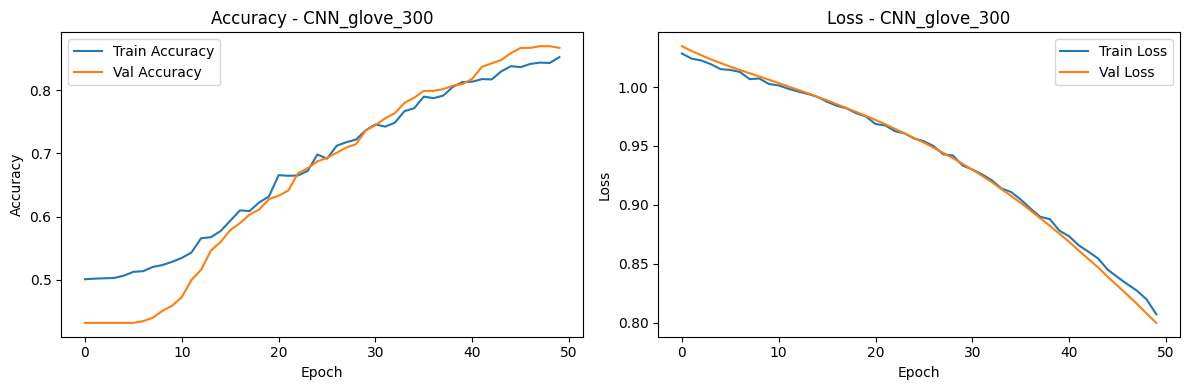

<Figure size 600x400 with 0 Axes>

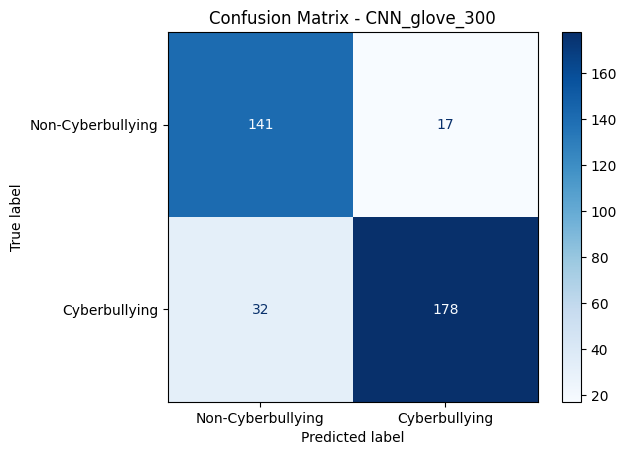

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.82      0.89      0.85       158
    Cyberbullying       0.91      0.85      0.88       210

         accuracy                           0.87       368
        macro avg       0.86      0.87      0.87       368
     weighted avg       0.87      0.87      0.87       368


📌 Training CNN: WORD2VEC 50D
📥 Loading Word2Vec from: /content/word2vec_id_50.bin

📌 Contoh kata dari WORD2VEC 50D:
bahagia: [-0.3022337  -2.8686457   1.7559555  -0.19663954  2.0469792 ]...
enggak: [ 0.15940285  0.41729936 -0.15476291 -0.569298    0.39537793]...
semangat: [-0.8418674 -5.7455716  2.903861   3.5248647  5.0374784]...
tolol: [-0.06165906  0.23464917 -0.02727623 -0.1659689  -0.10045199]...
norak: [-0.43134305  0.6263856  -0.24761565 -0.4325252   0.698999  ]...
banget: [-0.3524352   0.7922002  -0.45961514 -1.5537024   0.44823644]...
orang: [ 0.08901376 -5.1848483   3.6989958   6.164505    1.2454693 

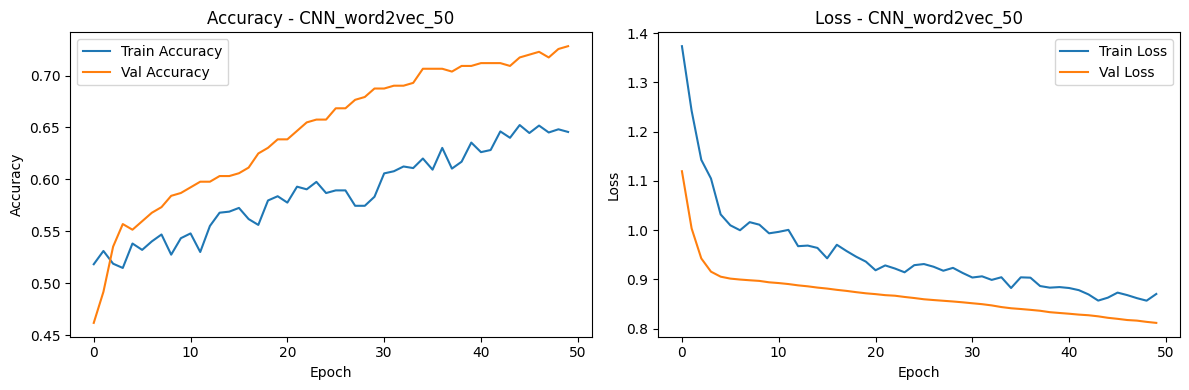

<Figure size 600x400 with 0 Axes>

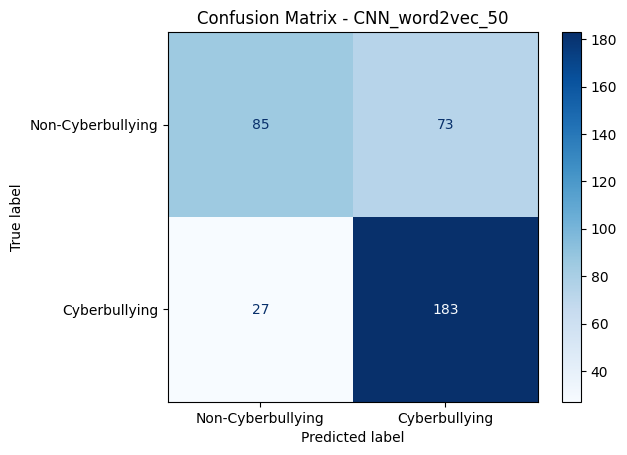

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.76      0.54      0.63       158
    Cyberbullying       0.71      0.87      0.79       210

         accuracy                           0.73       368
        macro avg       0.74      0.70      0.71       368
     weighted avg       0.73      0.73      0.72       368


📌 Training CNN: WORD2VEC 100D
📥 Loading Word2Vec from: /content/word2vec_id_100.bin

📌 Contoh kata dari WORD2VEC 100D:
bahagia: [ 3.1437027   0.537713   -1.6531277   0.92803085 -2.687515  ]...
enggak: [ 0.10905608  0.1304144  -0.26440609  0.33538952  0.36660677]...
semangat: [ 0.6373883  5.383101  -0.8477804  2.511306  -2.2876105]...
tolol: [ 0.00778567  0.01447748  0.08213059 -0.10732719 -0.11331836]...
norak: [ 0.16107692 -0.22466183 -0.43016976  0.22252126 -0.02939209]...
banget: [-0.20109758  0.25081342 -0.1920552   1.8164932   1.0989629 ]...
orang: [ 1.439967   3.062194   2.6841261  2.917476  -4.08261  ].

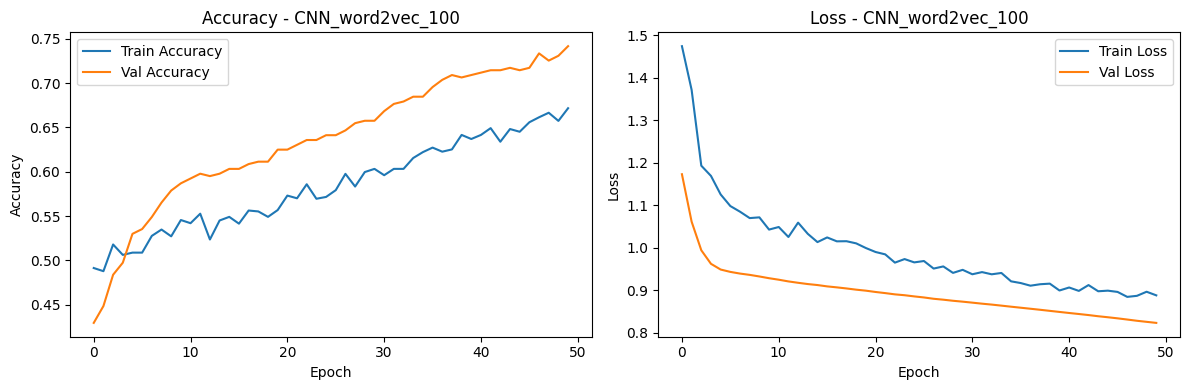

<Figure size 600x400 with 0 Axes>

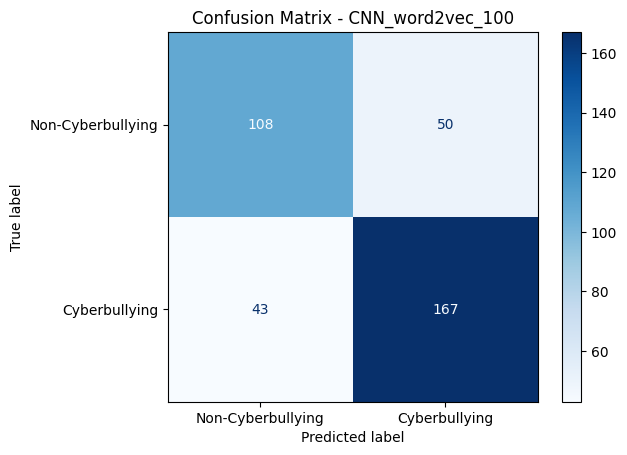

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.72      0.68      0.70       158
    Cyberbullying       0.77      0.80      0.78       210

         accuracy                           0.75       368
        macro avg       0.74      0.74      0.74       368
     weighted avg       0.75      0.75      0.75       368


📌 Training CNN: WORD2VEC 200D
📥 Loading Word2Vec from: /content/word2vec_id_200.bin

📌 Contoh kata dari WORD2VEC 200D:
bahagia: [ 2.934587   0.9318231 -1.246909   2.723685   1.2342818]...
enggak: [-0.05801967 -0.22771855 -0.88626504  1.1990705  -0.17378625]...
semangat: [ 1.3123378   0.94009113  1.1164782  -0.3647796   0.78177804]...
tolol: [ 0.09252032 -0.0524863  -0.22170584  0.51463574  0.12622167]...
norak: [ 0.7797513  -0.1558454  -0.45329452  0.8955188  -0.46652147]...
banget: [ 0.6252212  -0.49087802 -2.0690768   1.7529353  -0.09093203]...
orang: [1.1288401  0.18045494 2.4223437  0.3836807  1.1899974 ].

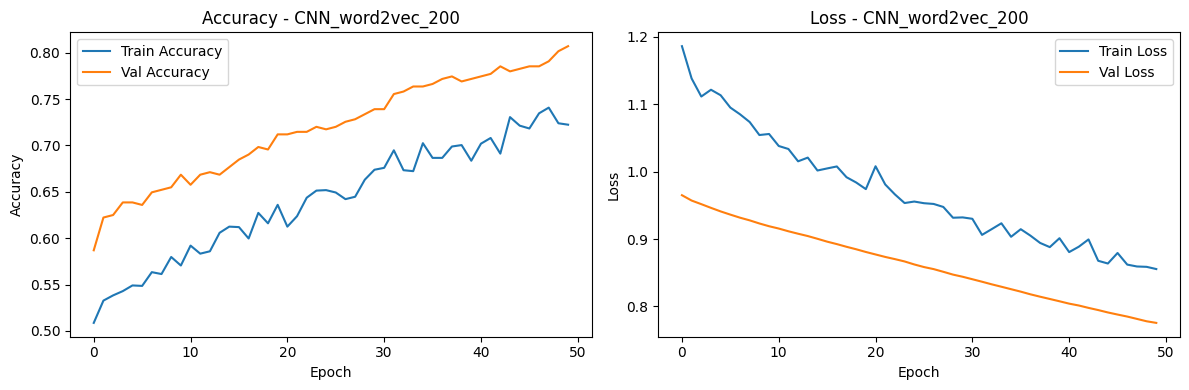

<Figure size 600x400 with 0 Axes>

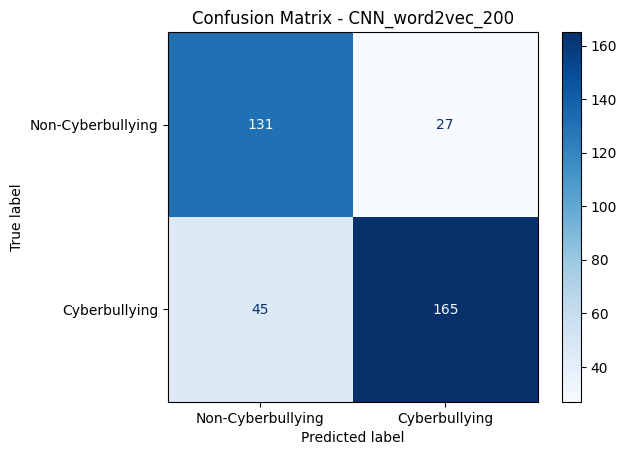

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.74      0.83      0.78       158
    Cyberbullying       0.86      0.79      0.82       210

         accuracy                           0.80       368
        macro avg       0.80      0.81      0.80       368
     weighted avg       0.81      0.80      0.81       368


📌 Training CNN: WORD2VEC 300D
📥 Loading Word2Vec from: /content/word2vec_id_300.bin

📌 Contoh kata dari WORD2VEC 300D:
bahagia: [ 1.1892209  1.0122477 -1.5196415  1.2461632 -2.5674062]...
enggak: [ 0.26331678  0.46014997  0.06069694  0.22554784 -0.46962708]...
semangat: [ 4.2209387  2.0135    -1.0294335  1.7380211 -1.9866049]...
tolol: [ 0.35378474  0.09190788 -0.04850911  0.01066863 -0.09223795]...
norak: [ 0.45710734  0.55222183 -0.269511    0.38458169 -0.2852784 ]...
banget: [ 0.17700985  1.4922363  -0.15857759  0.4049496  -0.7657361 ]...
orang: [ 3.4871535  -0.23594941  0.8692075   1.654903    1.6525487 ].

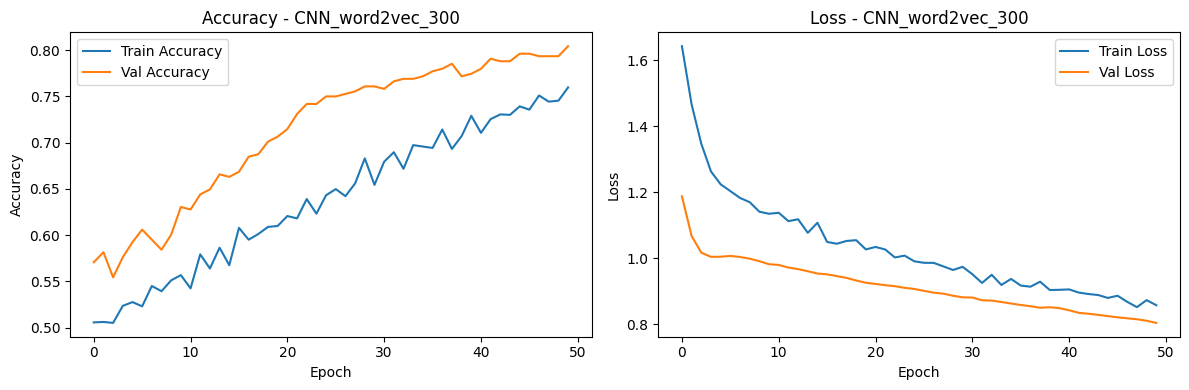

<Figure size 600x400 with 0 Axes>

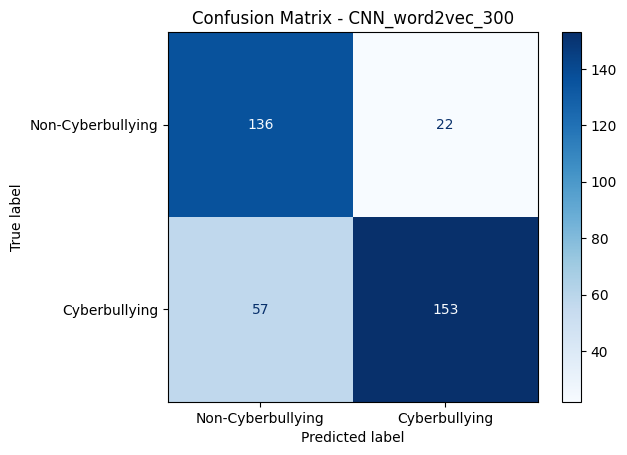

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.70      0.86      0.77       158
    Cyberbullying       0.87      0.73      0.79       210

         accuracy                           0.79       368
        macro avg       0.79      0.79      0.78       368
     weighted avg       0.80      0.79      0.79       368



Model  Validation Accuracy     AUC  Precision  Recall  F1-Score
0  CNN_fasttext_300               0.9076  0.9260     0.9154  0.8762    0.8954
1     CNN_glove_300               0.8696  0.9213     0.9128  0.8476    0.8790
2  CNN_word2vec_200               0.8071  0.8626     0.8594  0.7857    0.8209
3  CNN_word2vec_300               0.8043  0.8589     0.8743  0.7286    0.7948
4   CNN_word2vec_50               0.7283  0.7713     0.7148  0.8714    0.7854
5  CNN_word2vec_100               0.7418  0.8220     0.7696  0.7952    0.7822

In [ ]:
accuracy_results_cnn = {}

embedding_types = ['fasttext', 'glove', 'word2vec']
word2vec_dims = [50, 100, 200, 300]

for embedding_type in embedding_types:
    dims = [300] if embedding_type != 'word2vec' else word2vec_dims
    for dim in dims:
        print(f"\n📌 Training CNN: {embedding_type.upper()} {dim}D")
        embedding_matrix = load_embedding_matrix(embedding_type, tokenizer, dim)

        # Split
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

        # SMOTE
        X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

        # CNN Model
        inp = Input(shape=(max_len,))
        x = Embedding(input_dim=vocab_size, output_dim=dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(inp)
        x = Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = MaxPooling1D(pool_size=2)(x)
        x = Dropout(0.3)(x)
        x = Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = GlobalMaxPooling1D()(x)
        x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = Dropout(0.3)(x)
        out = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inp, outputs=out)
        model.compile(loss='binary_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy'])

        # Train
        early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
        history = model.fit(X_resampled, y_resampled, epochs=50, batch_size=64,
                            validation_data=(X_val, y_val), callbacks=[early_stop], verbose=0)

        # Predict & Evaluate
        y_proba = model.predict(X_test)
        y_pred = (y_proba > 0.5).astype("int32")

        acc = round(max(history.history['val_accuracy']), 4)
        auc = round(roc_auc_score(y_test, y_proba), 4)
        precision = round(precision_score(y_test, y_pred), 4)
        recall = round(recall_score(y_test, y_pred), 4)
        f1 = round(f1_score(y_test, y_pred), 4)

        print(f"✅ Best Validation Accuracy: {acc}")
        print(f"🟢 AUC Score: {auc}")

        model_key = f"CNN_{embedding_type}_{dim}"
        accuracy_results_cnn[model_key] = {
            'val_acc': acc,
            'auc': auc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

        # === Plot Accuracy & Loss ===
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title(f"Accuracy - {model_key}")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f"Loss - {model_key}")
        plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

        plt.tight_layout()
        plt.show()

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Cyberbullying", "Cyberbullying"])
        plt.figure(figsize=(6, 4))
        disp.plot(cmap="Blues", values_format="d")
        plt.title(f"Confusion Matrix - {model_key}")
        plt.show()

        # Classification Report
        print("📄 Classification Report:")
        print(classification_report(y_test, y_pred, target_names=["Non-Cyberbullying", "Cyberbullying"]))

# Buat DataFrame dari hasil
df_cnn = pd.DataFrame([
    {
        'Model': name,
        'Validation Accuracy': val['val_acc'],
        'AUC': val['auc'],
        'Precision': val['precision'],
        'Recall': val['recall'],
        'F1-Score': val['f1']
    }
    for name, val in accuracy_results_cnn.items()
])

# Urutkan berdasarkan F1-Score (atau bisa diganti dengan Accuracy)
df_cnn = df_cnn.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

# Tampilkan hasil akhir
df_cnn


# CNN LSTM


📌 Training CNN + LSTM: FASTTEXT 300D
📥 Loading FastText from: /content/drive/MyDrive/resources/cc.id.300.bin

📌 Contoh kata dari FASTTEXT 300D:
oov: [0.06179348 0.02740367 0.03621004 0.03203738 0.01887132]...
bahagia: [-0.00831283 -0.10030977 -0.02840042  0.06064843 -0.04130146]...
enggak: [-0.01656171  0.00548528  0.04379252  0.06003596 -0.02881695]...
semangat: [-0.05048427 -0.039581   -0.02468412  0.00075645 -0.04007722]...
tolol: [ 0.06908239  0.02892014 -0.0007012   0.08941144 -0.01374871]...
norak: [ 0.07936431  0.01482968 -0.07891081  0.01746366  0.01150789]...
banget: [ 0.00823963 -0.03834731  0.00525844  0.03335897 -0.05812761]...
orang: [ 0.04398865 -0.03032926 -0.01770458  0.12002504 -0.08117092]...
aku: [ 0.01258465 -0.05965358  0.09049556  0.29484874  0.02158902]...
sama: [ 0.07707722  0.0165033   0.05018882  0.06665502 -0.01466809]...

🔍 Total kata dalam tokenizer: 6098
🚫 Jumlah kata OOV: 0

🧠 Diagnostik kata penting:
'tolol': [ 0.06908239  0.02892014 -0.0007012   0.0894

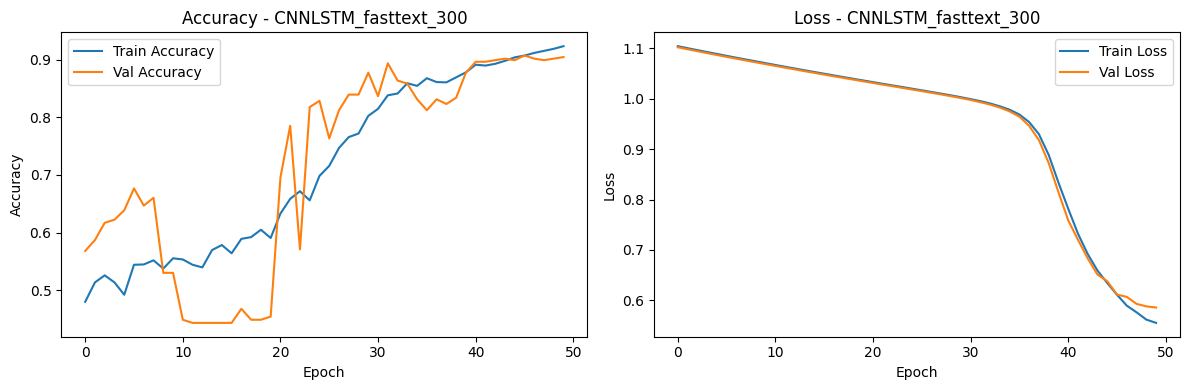

<Figure size 600x400 with 0 Axes>

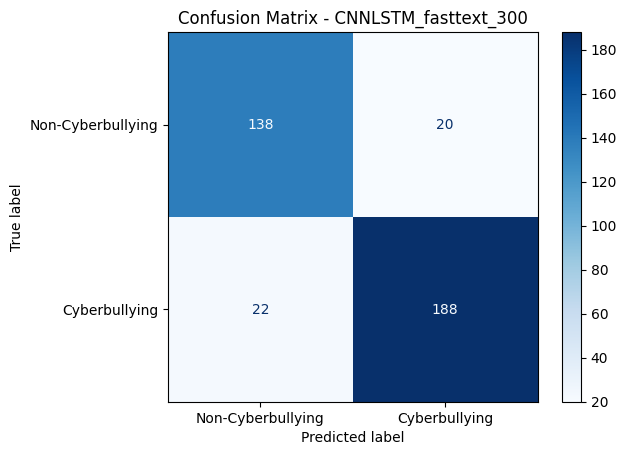

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.86      0.87      0.87       158
    Cyberbullying       0.90      0.90      0.90       210

         accuracy                           0.89       368
        macro avg       0.88      0.88      0.88       368
     weighted avg       0.89      0.89      0.89       368


📌 Training CNN + LSTM: GLOVE 300D
📥 Loading GloVe from: /content/glove_id.txt

📌 Contoh kata dari GLOVE 300D:
bahagia: [-0.00831283 -0.10030977 -0.02840042  0.06064843 -0.04130146]...
enggak: [-0.01656171  0.00548528  0.04379252  0.06003596 -0.02881695]...
semangat: [-0.05048427 -0.039581   -0.02468412  0.00075645 -0.04007722]...
tolol: [ 0.06908239  0.02892014 -0.0007012   0.08941144 -0.01374871]...
norak: [ 0.07936431  0.01482968 -0.07891081  0.01746366  0.01150789]...
banget: [ 0.00823963 -0.03834731  0.00525844  0.03335897 -0.05812761]...
orang: [ 0.04398865 -0.03032926 -0.01770458  0.12002504 -0.08117092]

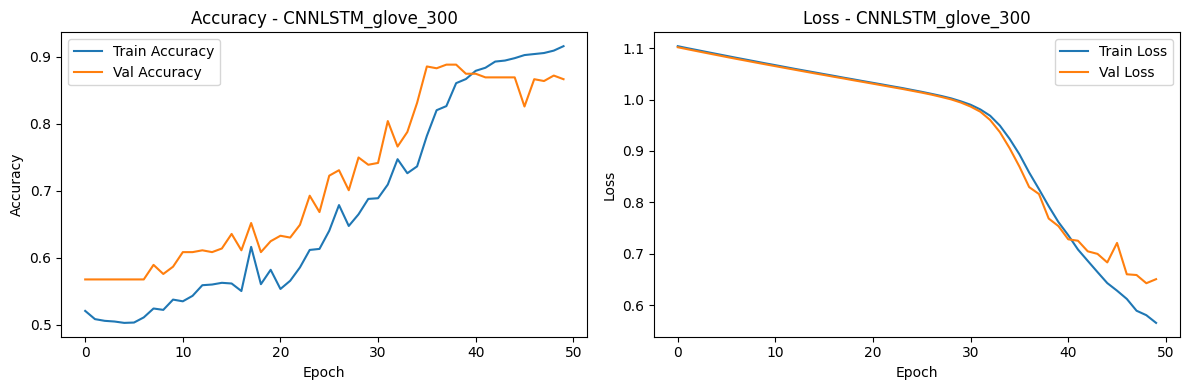

<Figure size 600x400 with 0 Axes>

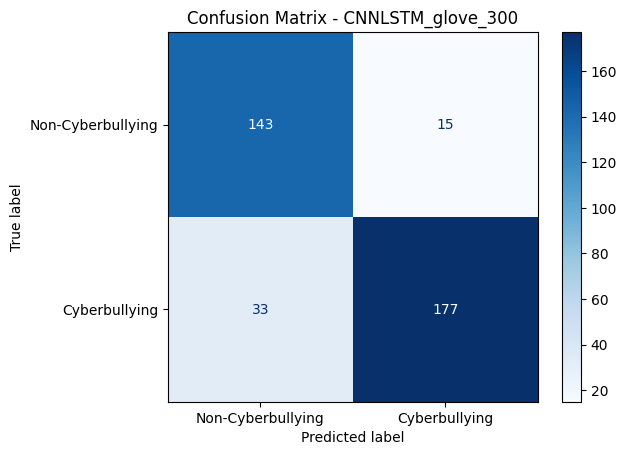

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.81      0.91      0.86       158
    Cyberbullying       0.92      0.84      0.88       210

         accuracy                           0.87       368
        macro avg       0.87      0.87      0.87       368
     weighted avg       0.87      0.87      0.87       368


📌 Training CNN + LSTM: WORD2VEC 50D
📥 Loading Word2Vec from: /content/word2vec_id_50.bin

📌 Contoh kata dari WORD2VEC 50D:
bahagia: [-0.3022337  -2.8686457   1.7559555  -0.19663954  2.0469792 ]...
enggak: [ 0.15940285  0.41729936 -0.15476291 -0.569298    0.39537793]...
semangat: [-0.8418674 -5.7455716  2.903861   3.5248647  5.0374784]...
tolol: [-0.06165906  0.23464917 -0.02727623 -0.1659689  -0.10045199]...
norak: [-0.43134305  0.6263856  -0.24761565 -0.4325252   0.698999  ]...
banget: [-0.3524352   0.7922002  -0.45961514 -1.5537024   0.44823644]...
orang: [ 0.08901376 -5.1848483   3.6989958   6.164505    1.2

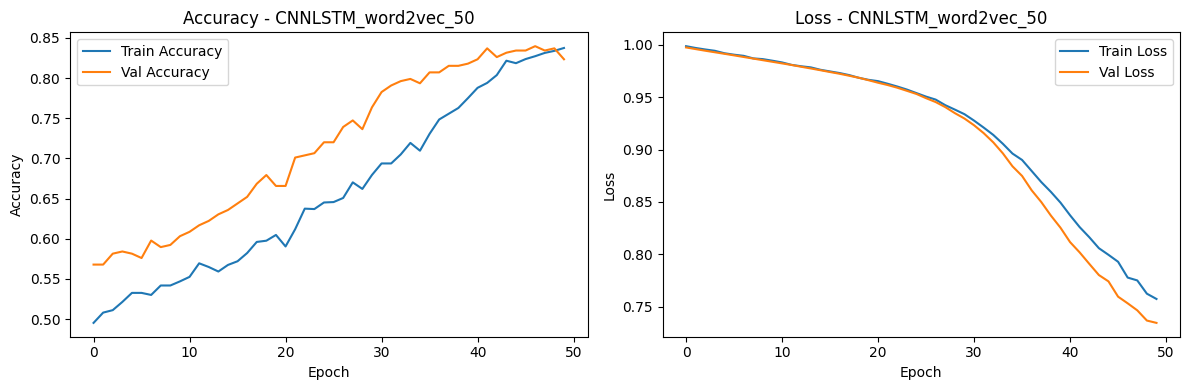

<Figure size 600x400 with 0 Axes>

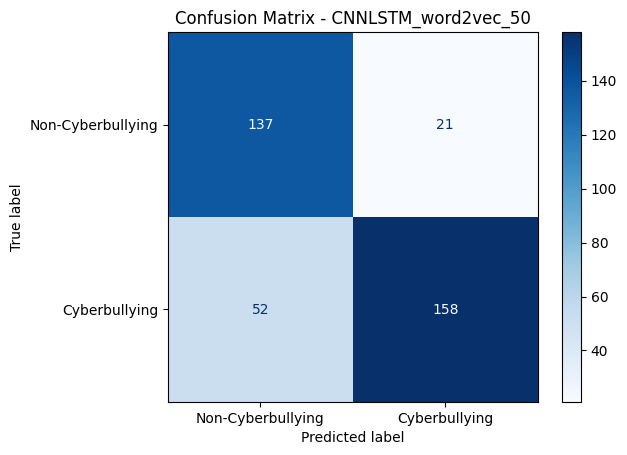

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.72      0.87      0.79       158
    Cyberbullying       0.88      0.75      0.81       210

         accuracy                           0.80       368
        macro avg       0.80      0.81      0.80       368
     weighted avg       0.81      0.80      0.80       368


📌 Training CNN + LSTM: WORD2VEC 100D
📥 Loading Word2Vec from: /content/word2vec_id_100.bin

📌 Contoh kata dari WORD2VEC 100D:
bahagia: [ 3.1437027   0.537713   -1.6531277   0.92803085 -2.687515  ]...
enggak: [ 0.10905608  0.1304144  -0.26440609  0.33538952  0.36660677]...
semangat: [ 0.6373883  5.383101  -0.8477804  2.511306  -2.2876105]...
tolol: [ 0.00778567  0.01447748  0.08213059 -0.10732719 -0.11331836]...
norak: [ 0.16107692 -0.22466183 -0.43016976  0.22252126 -0.02939209]...
banget: [-0.20109758  0.25081342 -0.1920552   1.8164932   1.0989629 ]...
orang: [ 1.439967   3.062194   2.6841261  2.917476  -4.08

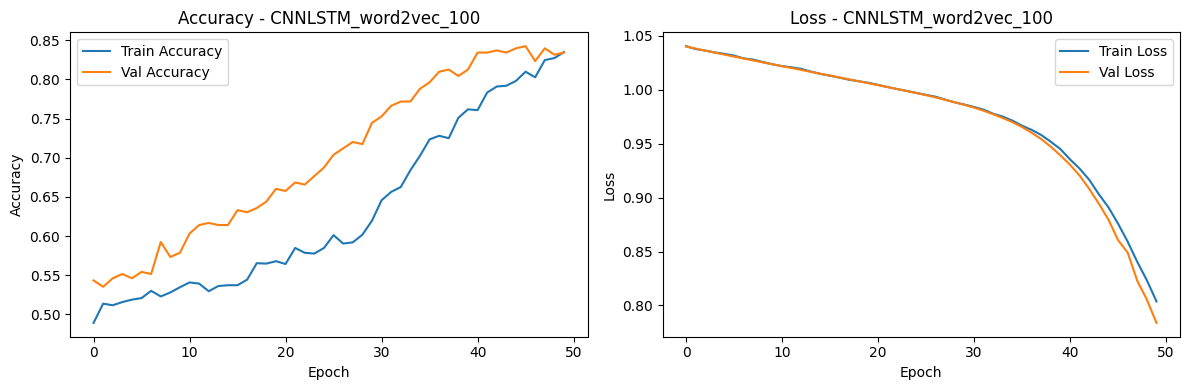

<Figure size 600x400 with 0 Axes>

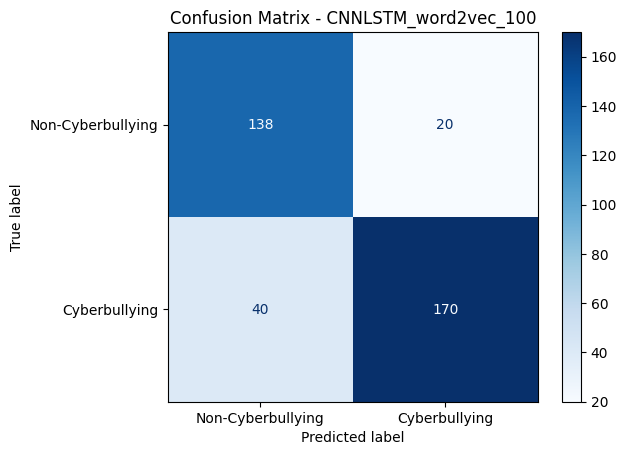

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.78      0.87      0.82       158
    Cyberbullying       0.89      0.81      0.85       210

         accuracy                           0.84       368
        macro avg       0.84      0.84      0.84       368
     weighted avg       0.84      0.84      0.84       368


📌 Training CNN + LSTM: WORD2VEC 200D
📥 Loading Word2Vec from: /content/word2vec_id_200.bin

📌 Contoh kata dari WORD2VEC 200D:
bahagia: [ 2.934587   0.9318231 -1.246909   2.723685   1.2342818]...
enggak: [-0.05801967 -0.22771855 -0.88626504  1.1990705  -0.17378625]...
semangat: [ 1.3123378   0.94009113  1.1164782  -0.3647796   0.78177804]...
tolol: [ 0.09252032 -0.0524863  -0.22170584  0.51463574  0.12622167]...
norak: [ 0.7797513  -0.1558454  -0.45329452  0.8955188  -0.46652147]...
banget: [ 0.6252212  -0.49087802 -2.0690768   1.7529353  -0.09093203]...
orang: [1.1288401  0.18045494 2.4223437  0.3836807  1.189

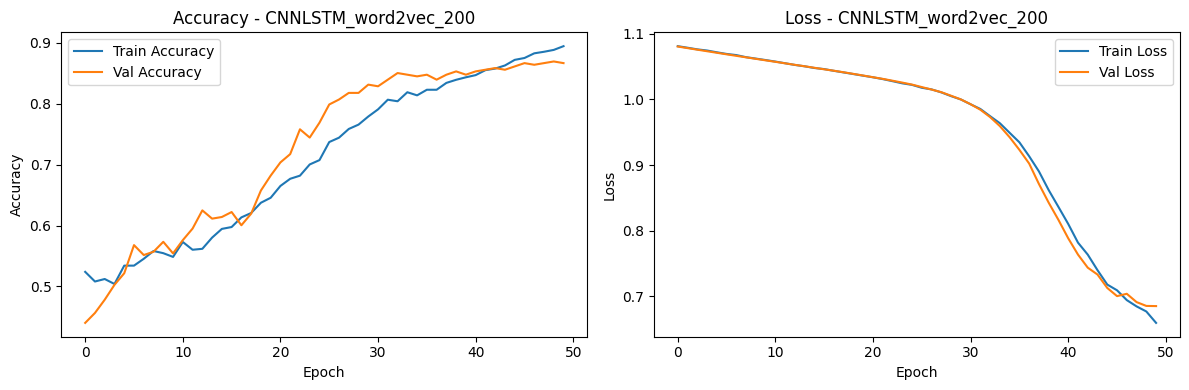

<Figure size 600x400 with 0 Axes>

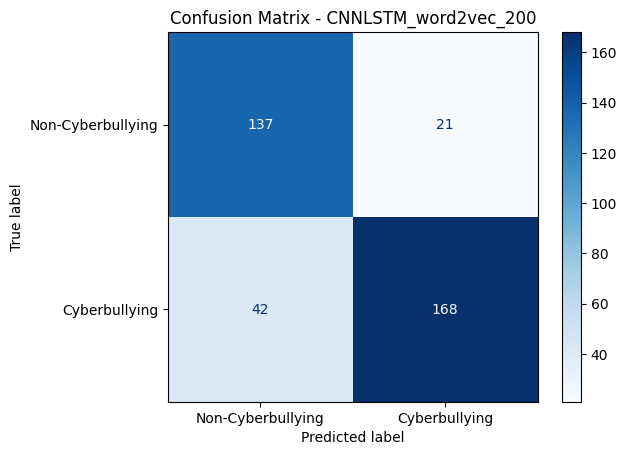

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.77      0.87      0.81       158
    Cyberbullying       0.89      0.80      0.84       210

         accuracy                           0.83       368
        macro avg       0.83      0.83      0.83       368
     weighted avg       0.84      0.83      0.83       368


📌 Training CNN + LSTM: WORD2VEC 300D
📥 Loading Word2Vec from: /content/word2vec_id_300.bin

📌 Contoh kata dari WORD2VEC 300D:
bahagia: [ 1.1892209  1.0122477 -1.5196415  1.2461632 -2.5674062]...
enggak: [ 0.26331678  0.46014997  0.06069694  0.22554784 -0.46962708]...
semangat: [ 4.2209387  2.0135    -1.0294335  1.7380211 -1.9866049]...
tolol: [ 0.35378474  0.09190788 -0.04850911  0.01066863 -0.09223795]...
norak: [ 0.45710734  0.55222183 -0.269511    0.38458169 -0.2852784 ]...
banget: [ 0.17700985  1.4922363  -0.15857759  0.4049496  -0.7657361 ]...
orang: [ 3.4871535  -0.23594941  0.8692075   1.654903    1.652

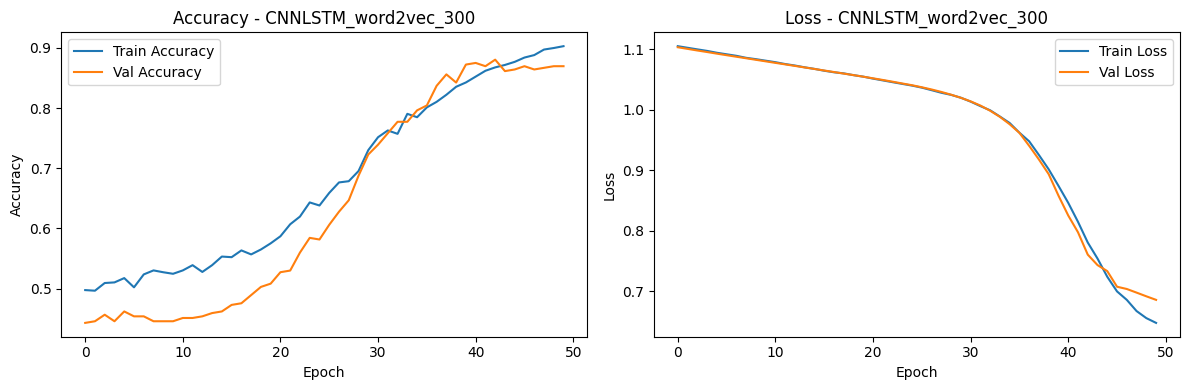

<Figure size 600x400 with 0 Axes>

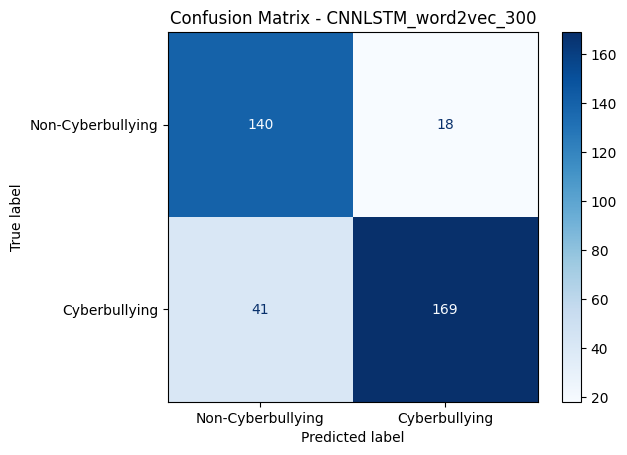

📄 Classification Report:
                   precision    recall  f1-score   support

Non-Cyberbullying       0.77      0.89      0.83       158
    Cyberbullying       0.90      0.80      0.85       210

         accuracy                           0.84       368
        macro avg       0.84      0.85      0.84       368
     weighted avg       0.85      0.84      0.84       368



Model  Validation Accuracy     AUC  Precision  Recall  \
0  CNNLSTM_fasttext_300               0.9076  0.9312     0.9038  0.8952   
1     CNNLSTM_glove_300               0.8886  0.9308     0.9219  0.8429   
2  CNNLSTM_word2vec_300               0.8804  0.8860     0.9037  0.8048   
3  CNNLSTM_word2vec_100               0.8424  0.8393     0.8947  0.8095   
4  CNNLSTM_word2vec_200               0.8696  0.8784     0.8889  0.8000   
5   CNNLSTM_word2vec_50               0.8397  0.8353     0.8827  0.7524   

   F1-Score  
0    0.8995  
1    0.8806  
2    0.8514  
3    0.8500  
4    0.8421  
5    0.8123

In [ ]:
# =================== CNN + LSTM ===================

accuracy_results_cnn_lstm = {}

embedding_types = ['fasttext', 'glove', 'word2vec']
word2vec_dims = [50, 100, 200, 300]

for embedding_type in embedding_types:
    dims = [300] if embedding_type != 'word2vec' else word2vec_dims
    for dim in dims:
        print(f"\n📌 Training CNN + LSTM: {embedding_type.upper()} {dim}D")
        embedding_matrix = load_embedding_matrix(embedding_type, tokenizer, dim)

        # Split 70:15:15
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

        # SMOTE hanya untuk train
        X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

        # === Build CNN + LSTM Model ===
        inp = Input(shape=(max_len,))
        x = Embedding(input_dim=vocab_size, output_dim=dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(inp)
        x = Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = MaxPooling1D(pool_size=2)(x)
        x = LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001))(x)
        x = Dropout(0.3)(x)
        x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = Dropout(0.3)(x)
        out = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inp, outputs=out)
        model.compile(loss='binary_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy'])

        # Training
        early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
        history = model.fit(
            X_resampled, y_resampled,
            epochs=50,
            batch_size=64,
            validation_data=(X_val, y_val),
            callbacks=[early_stop],
            verbose=0
        )

        # Prediction
        y_proba = model.predict(X_test)
        y_pred = (y_proba > 0.5).astype("int32")

        # Evaluation
        acc = round(max(history.history['val_accuracy']), 4)
        auc = round(roc_auc_score(y_test, y_proba), 4)
        precision = round(precision_score(y_test, y_pred), 4)
        recall = round(recall_score(y_test, y_pred), 4)
        f1 = round(f1_score(y_test, y_pred), 4)

        print(f"✅ Best Validation Accuracy: {acc}")
        print(f"🟢 AUC Score: {auc}")

        model_key = f"CNNLSTM_{embedding_type}_{dim}"
        accuracy_results_cnn_lstm[model_key] = {
            'val_acc': acc,
            'auc': auc,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

        # === Plot Accuracy & Loss ===
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title(f"Accuracy - {model_key}")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f"Loss - {model_key}")
        plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
        plt.tight_layout()
        plt.show()

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Cyberbullying", "Cyberbullying"])
        plt.figure(figsize=(6, 4))
        disp.plot(cmap="Blues", values_format="d")
        plt.title(f"Confusion Matrix - {model_key}")
        plt.show()

        # Classification Report
        print("📄 Classification Report:")
        print(classification_report(y_test, y_pred, target_names=["Non-Cyberbullying", "Cyberbullying"]))

# =================== BUAT DATAFRAME HASIL ===================

df_cnn_lstm = pd.DataFrame([
    {
        'Model': name,
        'Validation Accuracy': val['val_acc'],
        'AUC': val['auc'],
        'Precision': val['precision'],
        'Recall': val['recall'],
        'F1-Score': val['f1']
    }
    for name, val in accuracy_results_cnn_lstm.items()
])

df_cnn_lstm = df_cnn_lstm.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)
df_cnn_lstm

In [ ]:
# Gabungkan semua dictionary ke satu list
combined_results = []

# Fungsi bantu untuk parsing hasil
def append_results(source_dict, model_name):
    for key, val in source_dict.items():
        parts = key.split("_")
        embedding = parts[1]
        dim = parts[2]
        combined_results.append({
            'Model': model_name,
            'Embedding': embedding,
            'Dimension': dim,
            'Validation Accuracy': val['val_acc'],
            'AUC': val['auc'],
            'Precision': val.get('precision', None),
            'Recall': val.get('recall', None),
            'F1-Score': val.get('f1', None)
        })


# Gabungkan semua model
append_results(accuracy_results_cnn, 'CNN')
append_results(accuracy_results_lstm, 'LSTM')
append_results(accuracy_results_bilstm, 'BiLSTM')
append_results(accuracy_results_cnn_bilstm, 'CNN+BiLSTM')
append_results(accuracy_results_cnn_lstm, 'CNN+LSTM')

# Buat DataFrame akhir
df_all_models = pd.DataFrame(combined_results)

# Urutkan berdasarkan F1-Score, lalu Accuracy dan AUC (semua menurun)
df_all_models = df_all_models.sort_values(
    by=['F1-Score', 'Validation Accuracy', 'AUC'],
    ascending=[False, False, False]
).reset_index(drop=True)

# Tampilkan hasil akhir
df_all_models


Model Embedding Dimension  Validation Accuracy     AUC  Precision  \
0   CNN+BiLSTM  fasttext       300               0.9130  0.9410     0.9238   
1   CNN+BiLSTM  word2vec       300               0.9049  0.9248     0.9187   
2   CNN+BiLSTM     glove       300               0.9022  0.9377     0.9223   
3     CNN+LSTM  fasttext       300               0.9076  0.9312     0.9038   
4       BiLSTM     glove       300               0.8995  0.9307     0.9078   
5       BiLSTM  fasttext       300               0.9130  0.9276     0.9113   
6          CNN  fasttext       300               0.9076  0.9260     0.9154   
7   CNN+BiLSTM  word2vec       100               0.8750  0.9064     0.8868   
8   CNN+BiLSTM  word2vec       200               0.8750  0.9033     0.9184   
9         LSTM     glove       300               0.9022  0.9242     0.9137   
10      BiLSTM  word2vec       300               0.8859  0.9152     0.9010   
11    CNN+LSTM     glove       300               0.8886  0.9308     0.9219   
12         CNN     glove       300               0.8696  0.9213     0.9128   
13        LSTM  word2vec       300               0.8750  0.9191     0.9124   
14      BiLSTM  word2vec       200               0.8668  0.8975     0.8900   
15        LSTM  fasttext       300               0.9130  0.9250     0.9101   
16      BiLSTM  word2vec       100               0.8696  0.9022     0.8844   
17  CNN+BiLSTM  word2vec        50               0.8424  0.8860     0.8918   
18      BiLSTM  word2vec        50               0.8451  0.8700     0.8866   
19    CNN+LSTM  word2vec       300               0.8804  0.8860     0.9037   
20    CNN+LSTM  word2vec       100               0.8424  0.8393     0.8947   
21    CNN+LSTM  word2vec       200               0.8696  0.8784     0.8889   
22        LSTM  word2vec       200               0.8777  0.9092     0.9157   
23         CNN  word2vec       200               0.8071  0.8626     0.8594   
24    CNN+LSTM  word2vec        50               0.8397  0.8353     0.8827   
25        LSTM  word2vec       100               0.8016  0.7776     0.7585   
26        LSTM  word2vec        50               0.7446  0.7585     0.7723   
27         CNN  word2vec       300               0.8043  0.8589     0.8743   
28         CNN  word2vec        50               0.7283  0.7713     0.7148   
29         CNN  word2vec       100               0.7418  0.8220     0.7696   

    Recall  F1-Score  
0   0.9238    0.9238  
1   0.9143    0.9165  
2   0.9048    0.9135  
3   0.8952    0.8995  
4   0.8905    0.8990  
5   0.8810    0.8959  
6   0.8762    0.8954  
7   0.8952    0.8910  
8   0.8571    0.8867  
9   0.8571    0.8845  
10  0.8667    0.8835  
11  0.8429    0.8806  
12  0.8476    0.8790  
13  0.8429    0.8762  
14  0.8476    0.8683  
15  0.8190    0.8622  
16  0.8381    0.8606  
17  0.8238    0.8564  
18  0.8190    0.8515  
19  0.8048    0.8514  
20  0.8095    0.8500  
21  0.8000    0.8421  
22  0.7762    0.8402  
23  0.7857    0.8209  
24  0.7524    0.8123  
25  0.8524    0.8027  
26  0.8238    0.7972  
27  0.7286    0.7948  
28  0.8714    0.7854  
29  0.7952    0.7822

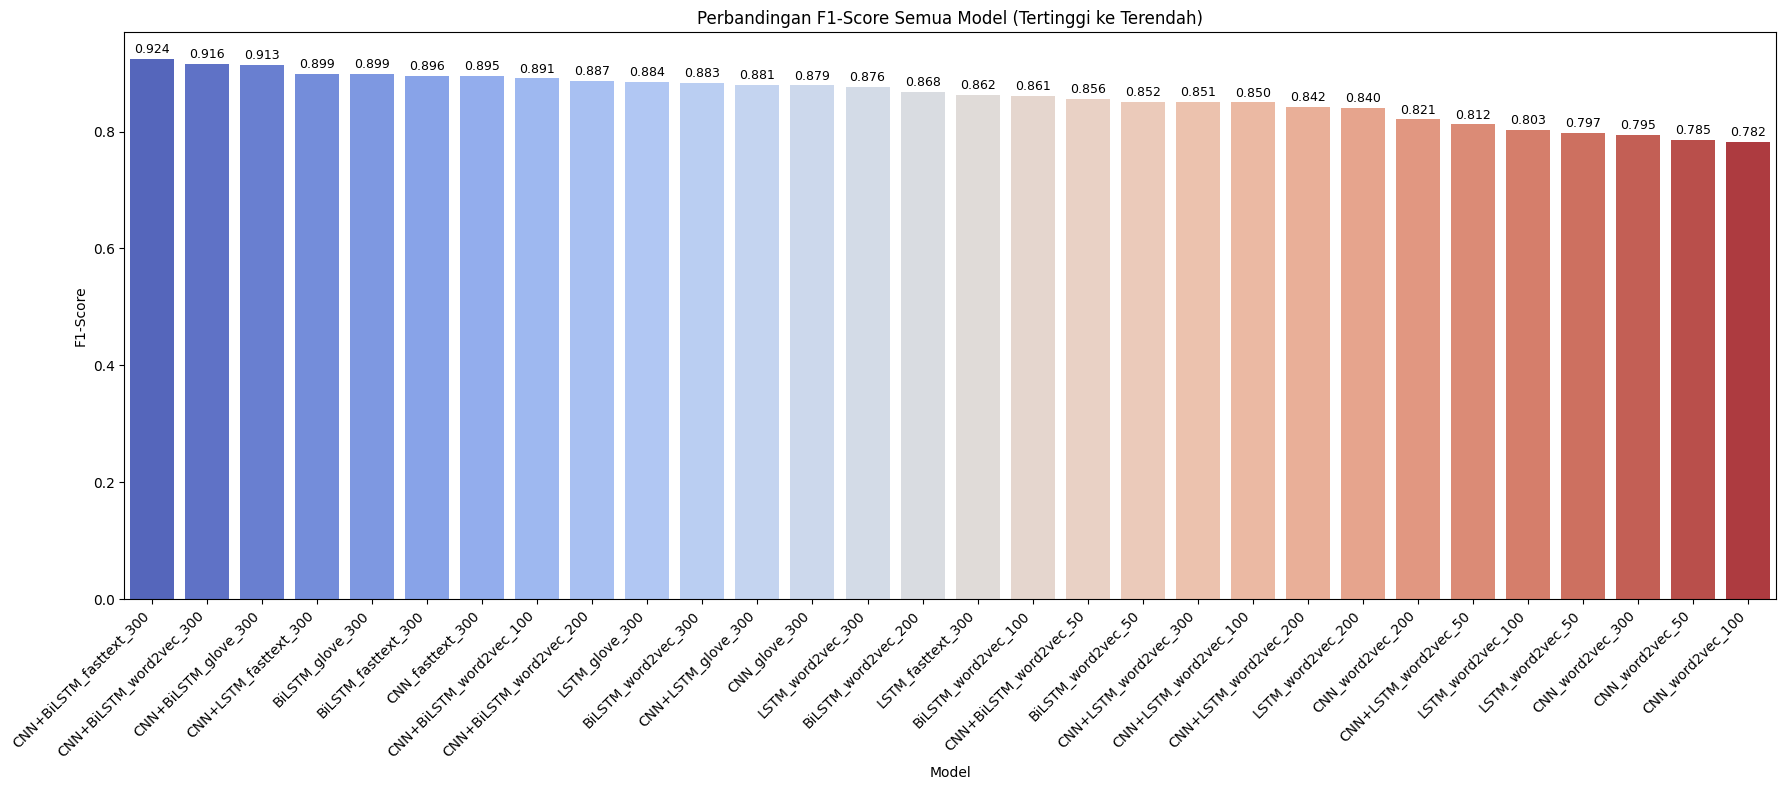

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Buat salinan dan hapus model yang tidak punya F1-Score
df_plot = df_all_models.dropna(subset=['F1-Score']).copy()

# Buat label gabungan: Model_Embedding_Dim
df_plot['Label'] = df_plot['Model'] + '_' + df_plot['Embedding'] + '_' + df_plot['Dimension']

# Urutkan berdasarkan F1-Score tertinggi ke terendah
df_plot = df_plot.sort_values(by='F1-Score', ascending=False)

# Set ukuran figure agar label tidak bertumpuk
plt.figure(figsize=(max(14, len(df_plot) * 0.6), 8))

# Plot bar chart vertikal
sns.barplot(data=df_plot, x='Label', y='F1-Score', palette='coolwarm')

# Tambahkan angka F1 di atas setiap bar
for i, val in enumerate(df_plot['F1-Score']):
    plt.text(i, val + 0.005, f"{val:.3f}", ha='center', va='bottom', fontsize=9)

# Rotasi label x agar terbaca
plt.xticks(rotation=45, ha='right')
plt.xlabel("Model")
plt.ylabel("F1-Score")
plt.title("Perbandingan F1-Score Semua Model (Tertinggi ke Terendah)")
plt.tight_layout()
plt.show()


In [ ]:
# ====== 1. Hitung rata-rata performa per embedding ======
df_avg_result = df_all_models.groupby("Embedding").agg({
    'Validation Accuracy': 'mean',
    'AUC': 'mean',
    'Precision': 'mean',
    'Recall': 'mean',
    'F1-Score': 'mean'
}).reset_index()

# Bulatkan hasil untuk tampilan lebih rapi
df_avg_result = df_avg_result.round(3)

# Urutkan berdasarkan F1-Score tertinggi
df_avg_result = df_avg_result.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

# Tampilkan hasil tabel rekap rata-rata
print("📊 Rata-rata performa tiap word embedding:")
from IPython.display import display
display(df_avg_result)


📊 Rata-rata performa tiap word embedding:


Embedding  Validation Accuracy    AUC  Precision  Recall  F1-Score
0  fasttext                0.911  0.930      0.913   0.879     0.895
1     glove                0.892  0.929      0.916   0.869     0.891
2  word2vec                0.839  0.866      0.866   0.825     0.843